# 1. 라이브러리 로드

In [114]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [115]:
google_trend_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/total_google_trend.csv', index_col=0)
google_trend_df['date'] = pd.to_datetime(google_trend_df['date'])
google_trend_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16511 entries, 0 to 16510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16511 non-null  datetime64[ns]
 1   trend   16511 non-null  int64         
 2   artist  16511 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 516.0+ KB


In [116]:
google_trend_test_df = pd.read_excel('/content/drive/MyDrive/sogang_thesis_prj/dataset/test_google_trend.xlsx')
google_trend_test_df['date'] = pd.to_datetime(google_trend_test_df['date'])

google_trend_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    279 non-null    datetime64[ns]
 1   trend   279 non-null    int64         
 2   artist  279 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.7+ KB


In [117]:
artist_info_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/top5_group_info.csv', index_col=0)
artist_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4839 entries, 0 to 4838
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   artist_name          4839 non-null   object 
 1   artist_id            4839 non-null   object 
 2   debut_date           4839 non-null   object 
 3   artist_types         4839 non-null   object 
 4   member_cnt           4839 non-null   int64  
 5   sub_group_cnt        4839 non-null   int64  
 6   label                4734 non-null   object 
 7   album_id             4839 non-null   object 
 8   album_name           4839 non-null   object 
 9   album_type           4839 non-null   object 
 10  release_date         4839 non-null   object 
 11  main_genre           0 non-null      float64
 12  sub_genre            0 non-null      float64
 13  track_cnt            4839 non-null   int64  
 14  avg_track_play_time  4749 non-null   float64
 15  participant_type     4839 non-null   object

In [118]:
google_trend_df['artist'].unique()

array(['aespa', 'BLACKPINK', 'BTS', 'IVE', 'NCT DREAM', 'NewJeans',
       'SEVENTEEN', 'Stray Kids', 'TOMORROW X TOGETHER', 'TWICE'],
      dtype=object)

In [119]:
google_trend_df.groupby('artist').count()['date'].sort_values()

artist
NewJeans                710
IVE                     973
aespa                  1345
SEVENTEEN              1836
BLACKPINK              1875
NCT DREAM              1890
TWICE                  1946
BTS                    1957
Stray Kids             1985
TOMORROW X TOGETHER    1994
Name: date, dtype: int64

In [120]:
# seasonal decompose 내 EDA 결과, NCT Dream의 경우 0값이 많으므로 해당 아티스트 제거
google_trend_df = google_trend_df[google_trend_df['artist'] != 'NCT DREAM']
google_trend_df

date  trend artist
0     2020-10-25      0  aespa
1     2020-10-26      0  aespa
2     2020-10-27      0  aespa
3     2020-10-28      0  aespa
4     2020-10-29      0  aespa
...          ...    ...    ...
16506 2024-06-26     24  TWICE
16507 2024-06-27     23  TWICE
16508 2024-06-28     20  TWICE
16509 2024-06-29     34  TWICE
16510 2024-06-30     30  TWICE

[14621 rows x 3 columns]

# 3. 전처리

In [121]:
google_trend_df.set_index('date', inplace=True)

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose

# trend2: artist별 time interpolation & backward fill 수행
# trend3: artist별 trend 지수 추세선 제거 적용
google_trend_df_list = []
for artist in google_trend_df['artist'].unique():

    single_artist_trend_df = google_trend_df.query(f"artist == '{artist}'")

    # trend3
    decomposition = seasonal_decompose(single_artist_trend_df['trend'], model='additive', period=12)
    trend = decomposition.trend

    single_artist_trend_df['trend3'] = single_artist_trend_df['trend'] - trend
    single_artist_trend_df['trend3'] = single_artist_trend_df['trend3'].interpolate(method='time').fillna(method='bfill')

    # trend2
    single_artist_trend_df.loc[single_artist_trend_df['trend'] == 0, 'trend'] = np.NaN # 0인 trend 값 interpolation 수행
    single_artist_trend_df['trend2'] = single_artist_trend_df['trend'].interpolate(method='time').fillna(method='bfill')

    google_trend_df_list.append(single_artist_trend_df)

google_trend_df2 = pd.concat(google_trend_df_list).reset_index()
google_trend_df2

date  trend artist    trend3  trend2
0     2020-10-25    NaN  aespa  0.000000     8.0
1     2020-10-26    NaN  aespa  0.000000     8.0
2     2020-10-27    NaN  aespa  0.000000     8.0
3     2020-10-28    NaN  aespa  0.000000     8.0
4     2020-10-29    NaN  aespa  0.000000     8.0
...          ...    ...    ...       ...     ...
14616 2024-06-26   24.0  TWICE -5.333333    24.0
14617 2024-06-27   23.0  TWICE -5.333333    23.0
14618 2024-06-28   20.0  TWICE -5.333333    20.0
14619 2024-06-29   34.0  TWICE -5.333333    34.0
14620 2024-06-30   30.0  TWICE -5.333333    30.0

[14621 rows x 5 columns]

In [131]:
google_trend_test_df.set_index('date', inplace=True)

In [133]:
google_trend_test_df_list = []
for artist in google_trend_test_df['artist'].unique():

    single_artist_trend_test_df = google_trend_test_df.query(f"artist == '{artist}'")

    # trend3
    decomposition = seasonal_decompose(single_artist_trend_test_df['trend'], model='additive', period=12)
    trend = decomposition.trend

    single_artist_trend_test_df['trend3'] = single_artist_trend_test_df['trend'] - trend
    single_artist_trend_test_df['trend3'] = single_artist_trend_test_df['trend3'].interpolate(method='time').fillna(method='bfill')

    google_trend_test_df_list.append(single_artist_trend_test_df)

google_trend_test_df2 = pd.concat(google_trend_test_df_list).reset_index()
google_trend_test_df2

date  trend artist    trend3
0   2024-07-01     76  aespa  3.083333
1   2024-07-02     87  aespa  3.083333
2   2024-07-03    100  aespa  3.083333
3   2024-07-04     96  aespa  3.083333
4   2024-07-05     67  aespa  3.083333
..         ...    ...    ...       ...
274 2024-07-27     46  TWICE  0.708333
275 2024-07-28     50  TWICE  0.708333
276 2024-07-29     43  TWICE  0.708333
277 2024-07-30     47  TWICE  0.708333
278 2024-07-31    100  TWICE  0.708333

[279 rows x 4 columns]

In [123]:
artist_info_df[['artist_name', 'debut_date']].drop_duplicates().sort_values('debut_date')

artist_name  debut_date
200                   BTS  2013-06-13
0               SEVENTEEN  2015-05-26
1564                TWICE  2015-07-07
1739            BLACKPINK  2016-08-08
900             NCT DREAM  2016-08-24
650            Stray Kids  2017-10-17
1084  TOMORROW X TOGETHER  2019-01-10
1364                aespa  2020-10-25
1259                  IVE  2021-11-01
1464             NewJeans  2022-07-22

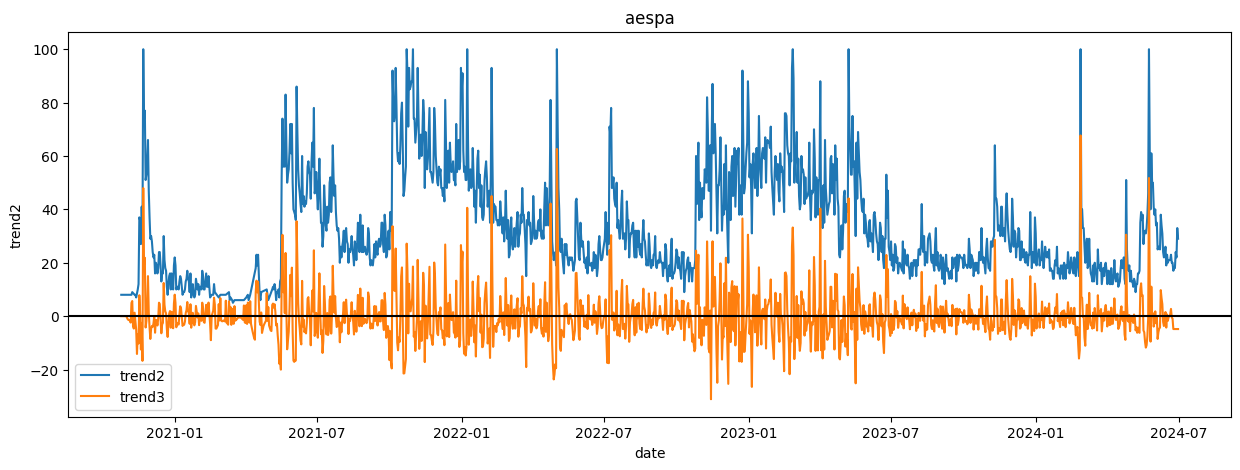

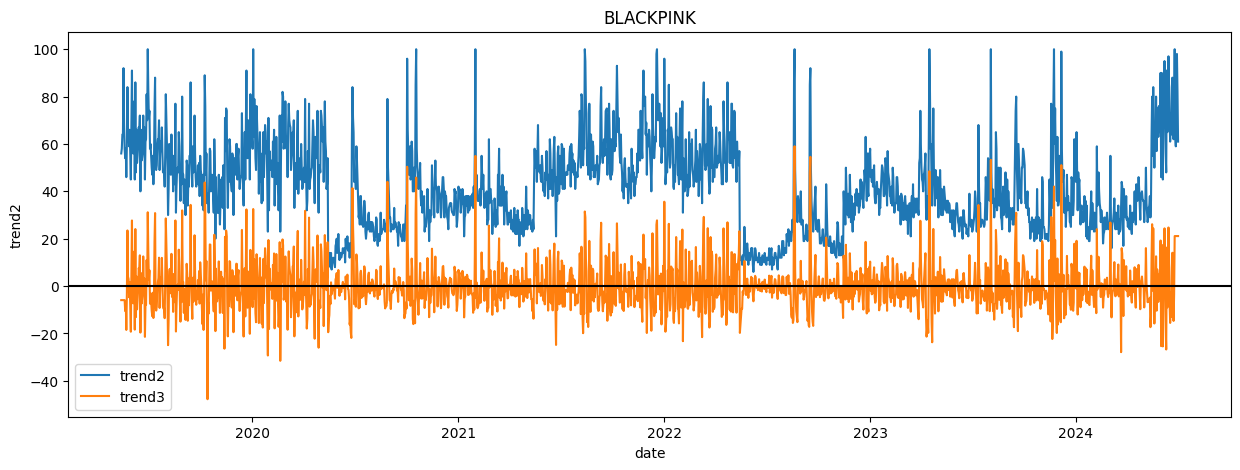

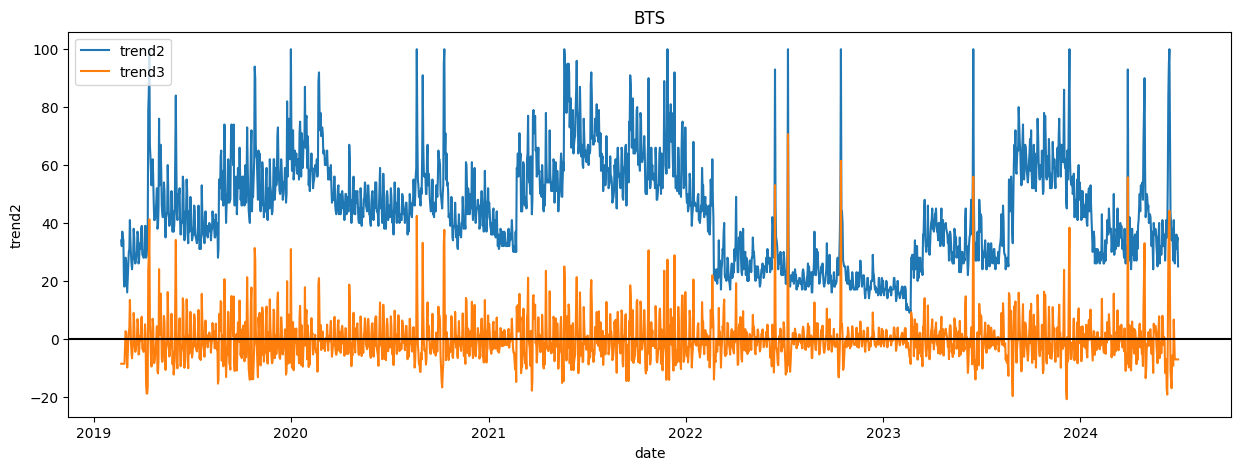

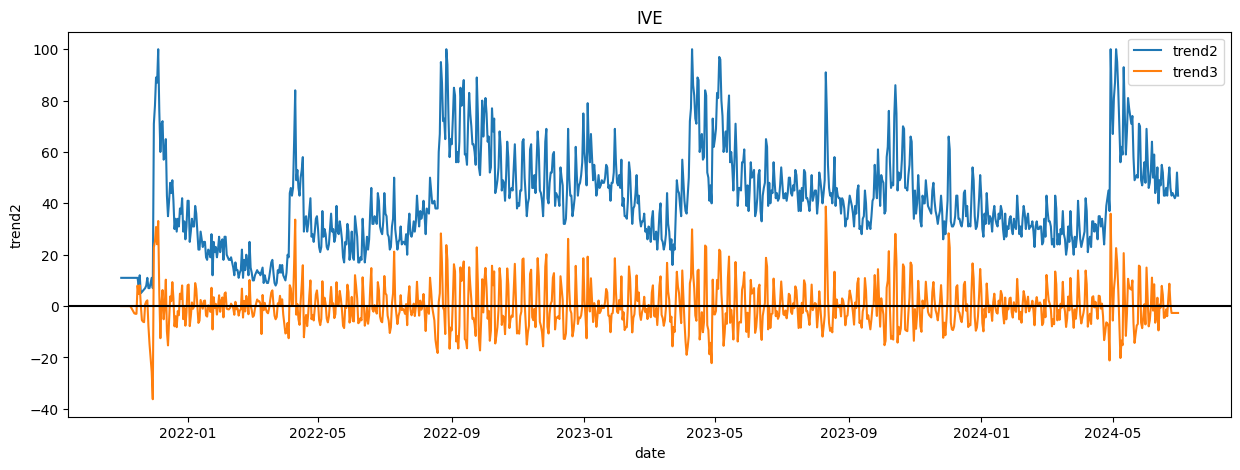

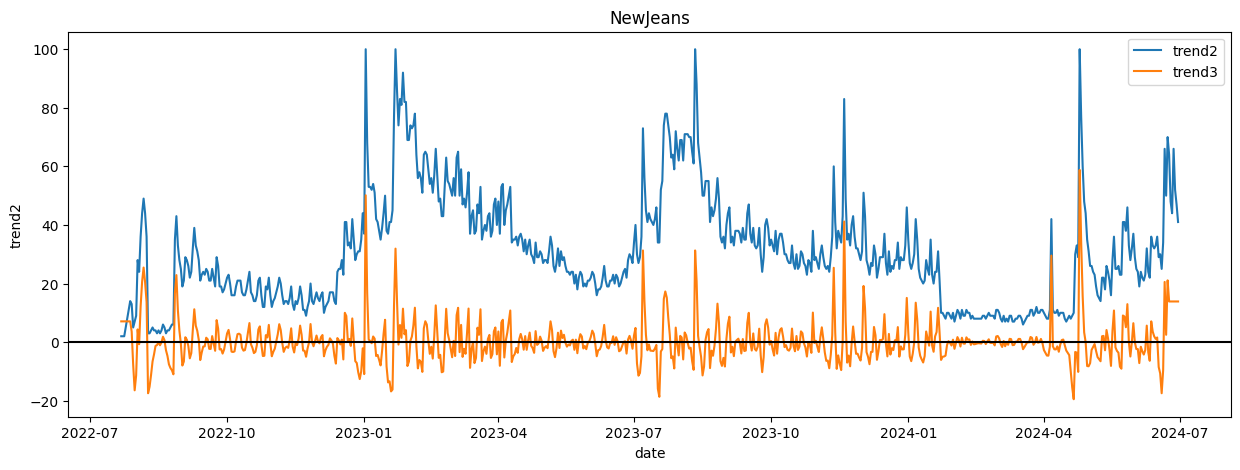

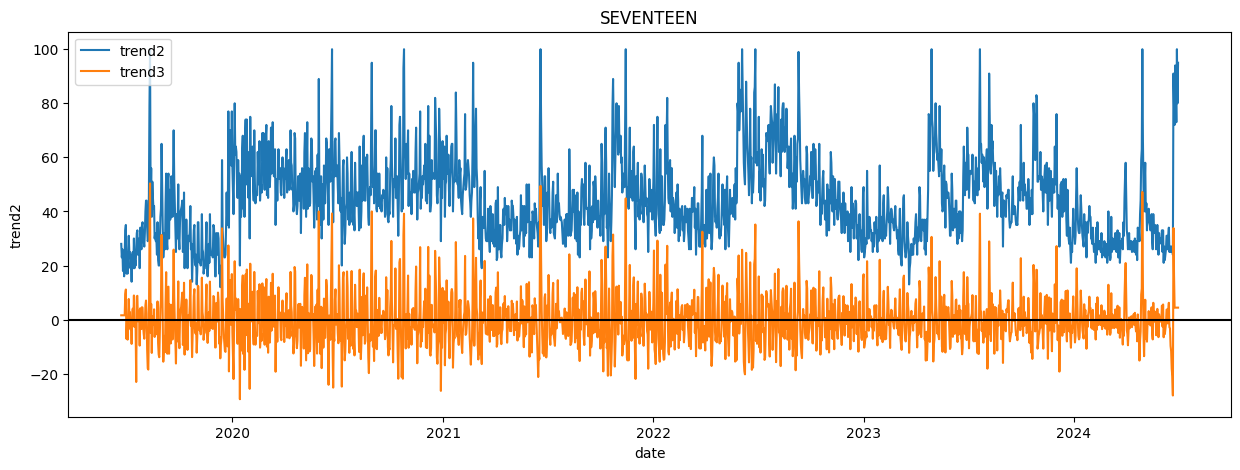

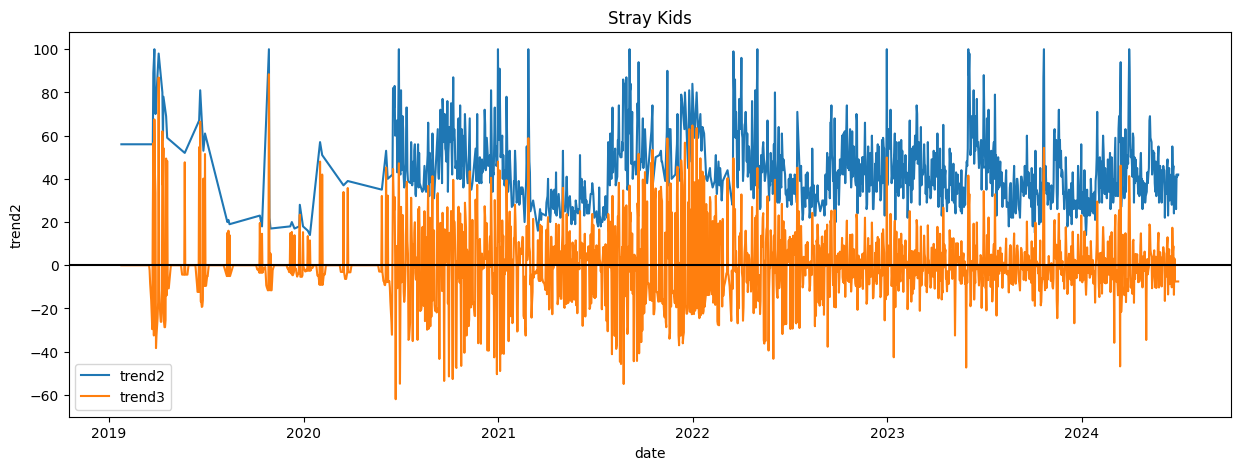

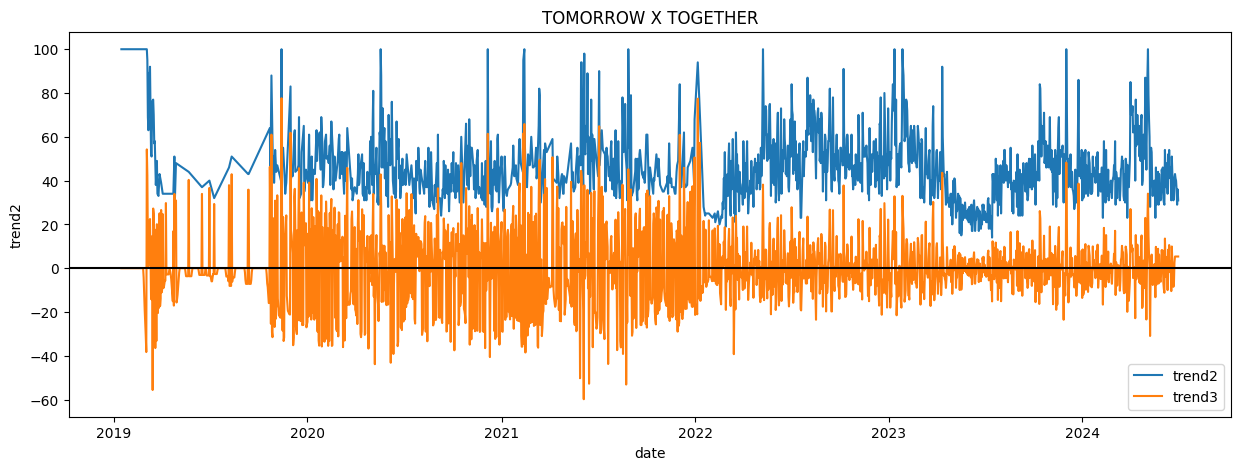

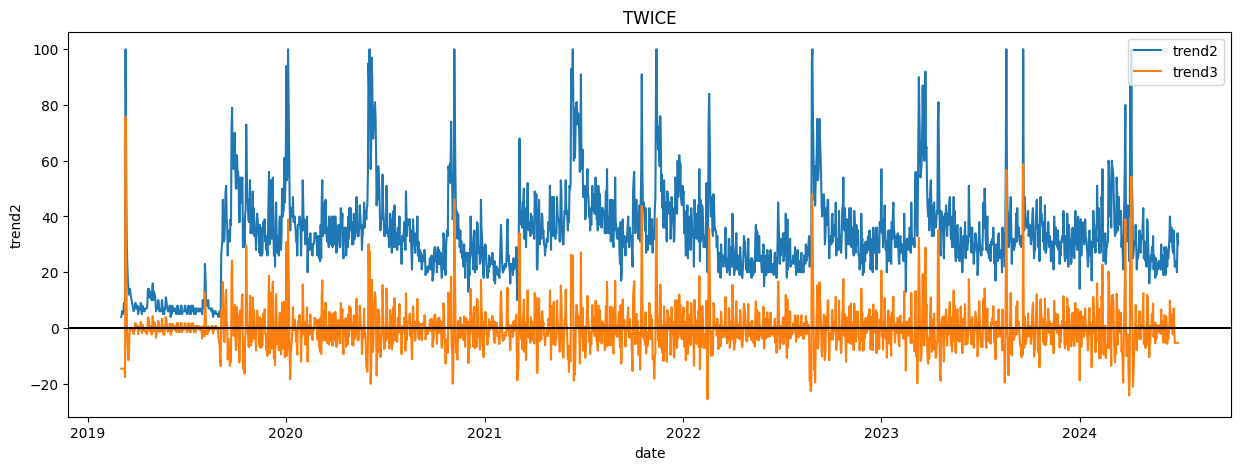

In [124]:
for artist in google_trend_df2['artist'].unique():

    plt.figure(figsize=(15, 5))

    plt.title(artist)
    sns.lineplot(
        data=google_trend_df2[google_trend_df2['artist'] == artist],
        x='date',
        y='trend2',
        label='trend2'
    )

    sns.lineplot(
        data=google_trend_df2[google_trend_df2['artist'] == artist],
        x='date',
        y='trend3',
        label='trend3'
    )

    plt.axhline(y=0, color='black')

    plt.legend()
    plt.show()

# 4. 정상성 검정
* p-value
  * 의미: p-value는 귀무가설(null hypothesis)이 맞을 확률을 나타내며, 일반적으로 귀무가설은 "데이터에 단위근이 존재한다"라는 가정을 의미
  * 단위근: 오늘의 영향력이 미래에 어느 정도 영향을 미치는지를 결정하는 모수
  * p-value < 0.05: 귀무가설을 기각합니다. 즉, 데이터가 정상성을 가진다고 판단할 수 있습니다.
  * p-value >= 0.05: 귀무가설을 기각하지 못합니다. 즉, 데이터가 비정상성을 가진다고 판단할 수 있습니다.

* ADF Statistic
  * 의미: ADF 통계량은 시계열 데이터에 단위근이 존재하는지 여부를 판단하는 데 사용되는 값입니다.
  * 해석: ADF 통계량이 음수일수록 데이터가 정상성을 가질 가능성이 높습니다. 이 값은 임계값과 비교하여 해석됩니다.
  * 1에 가까울수록 오늘의 영향력이 내일에 영향을 미칠 가능성이 크다는 것을 뜻함. 비정상성을 띈다고 해석

* ACF & PACF
  * ACF: 현재 값과 과거 값들 사이의 상관관계 측정
  * PACF: 특정 시차에서의 부분 자기상관 측정
  * ARIMA 모델의 p, d, q 파라미터 최적 차수 탐색 시 유용하게 사용됨

In [ ]:
!pip install statsmodels

In [125]:
from statsmodels.tsa.stattools import adfuller

In [126]:
'''
  - NewJeans의 경우, p-value값, ADF Statistic 값 보았을 때, 비정상성을 갖는 데이터로 파악됨
'''
for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist].query("date >= '2023-06-30'")

    result = adfuller(trend_df['trend2'])
    print(f"<<< {artist} >>>")
    print(f"ADF Statistic = {result[0]}")
    print(f"p-value = {result[1]}")
    print(f"Critical Values = {result[4]}")

    print('\n')

<<< aespa >>>
ADF Statistic = -5.216168237899104
p-value = 8.14786561126747e-06
Critical Values = {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}


<<< BLACKPINK >>>
ADF Statistic = -1.376812824499832
p-value = 0.5933404881210769
Critical Values = {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}


<<< BTS >>>
ADF Statistic = -2.7473405053256235
p-value = 0.066198383831352
Critical Values = {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}


<<< IVE >>>
ADF Statistic = -2.792127198959744
p-value = 0.05940717142953713
Critical Values = {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}


<<< NewJeans >>>
ADF Statistic = -1.7313763879158417
p-value = 0.4150232076280635
Critical Values = {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}


<<< SEVENTEEN >>>
ADF Statistic = -3.588115860448916
p-value = 0.005992333957434516
Critical Values

In [127]:
'''
  - 추세 제거된 트렌드 지수 검정 결과, trend2와 비교할 때 비정상성 많이 제거됨
'''
for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist].query("date >= '2023-06-30'")

    result = adfuller(trend_df['trend3'])
    print(f"<<< {artist} >>>")
    print(f"ADF Statistic = {result[0]}")
    print(f"p-value = {result[1]}")
    print(f"Critical Values = {result[4]}")

    print('\n')

<<< aespa >>>
ADF Statistic = -8.953640269427646
p-value = 8.589790583874704e-15
Critical Values = {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}


<<< BLACKPINK >>>
ADF Statistic = -5.903421622569685
p-value = 2.7439083676863473e-07
Critical Values = {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}


<<< BTS >>>
ADF Statistic = -8.224893785282015
p-value = 6.284867210858128e-13
Critical Values = {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}


<<< IVE >>>
ADF Statistic = -9.838135920251517
p-value = 4.8334755977095235e-17
Critical Values = {'1%': -3.448905534655263, '5%': -2.8697161816205705, '10%': -2.5711258103550882}


<<< NewJeans >>>
ADF Statistic = -6.552018376146863
p-value = 8.802773573560317e-09
Critical Values = {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}


<<< SEVENTEEN >>>
ADF Statistic = -7.884898529912754
p-value = 4.597563286793385e-1

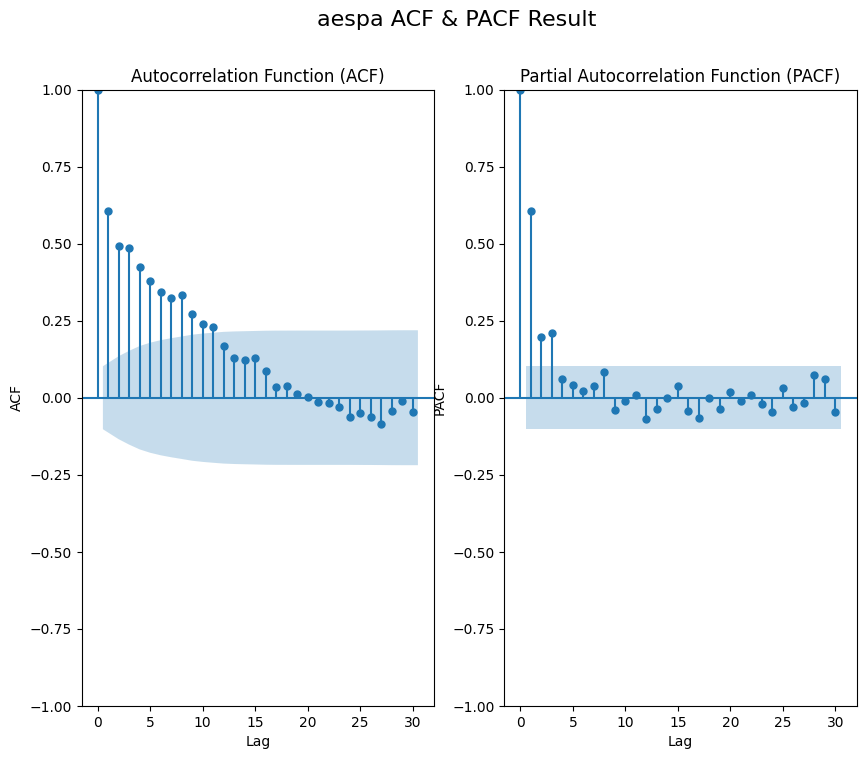

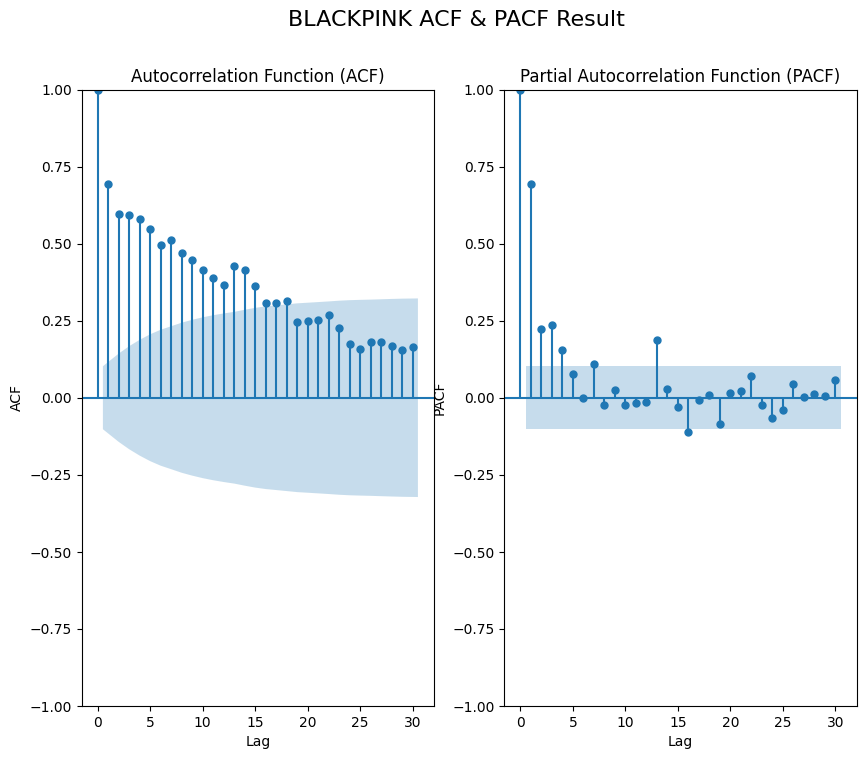

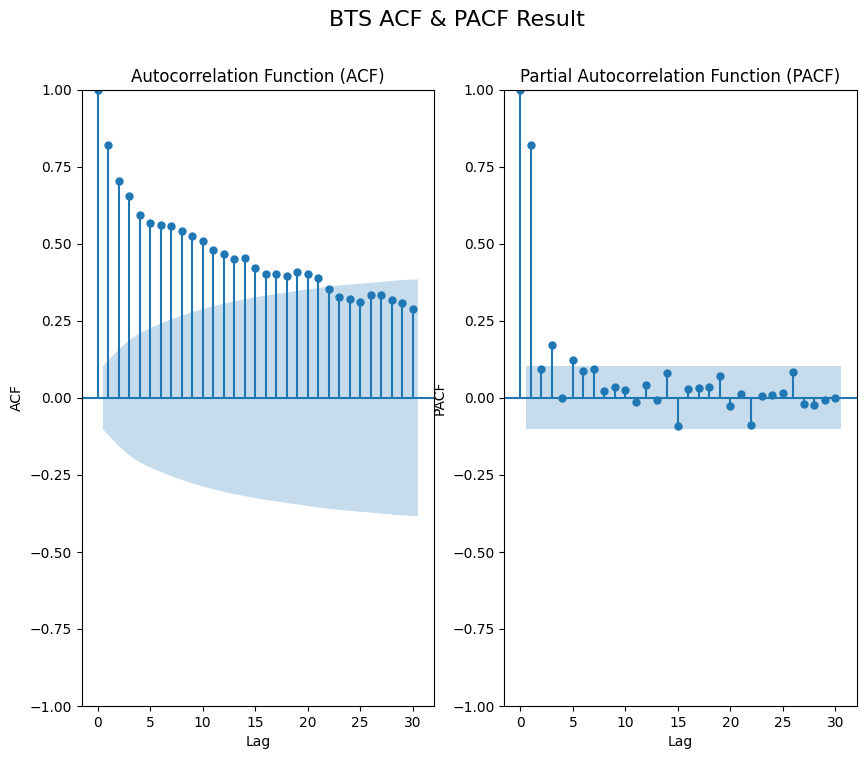

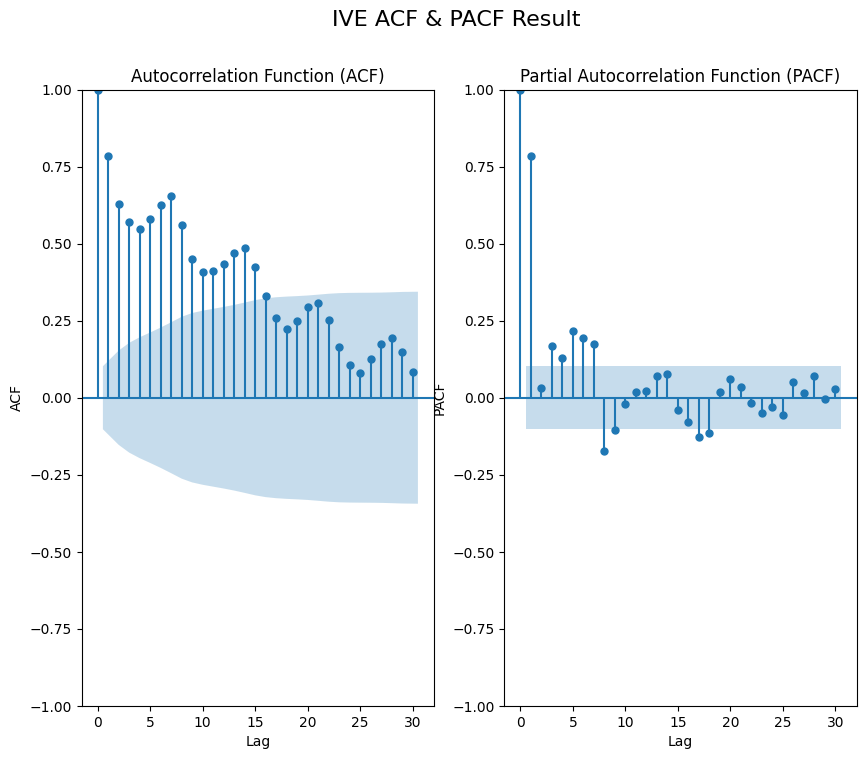

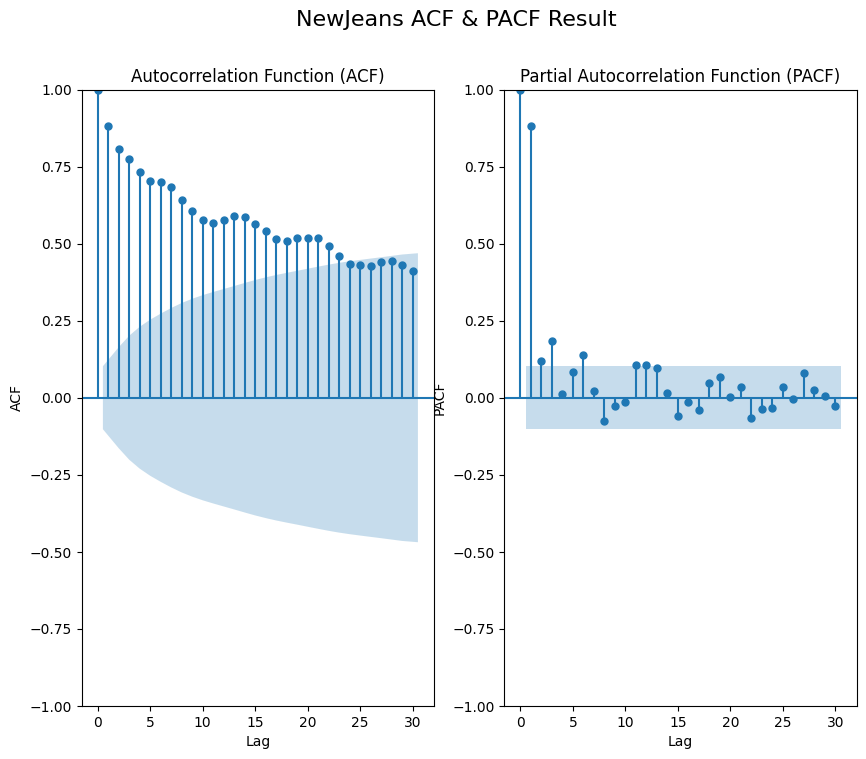

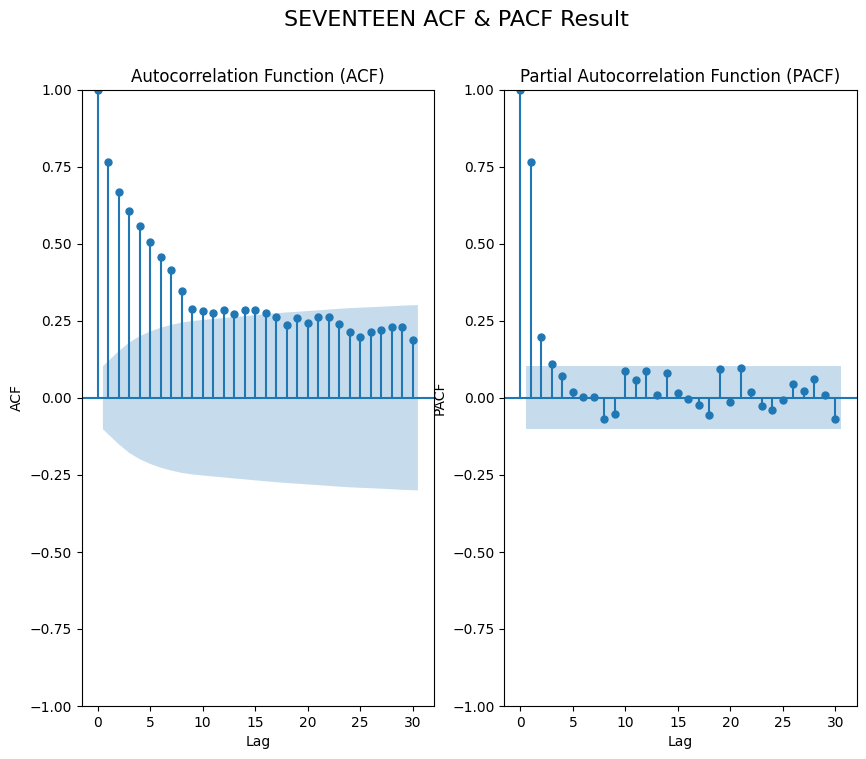

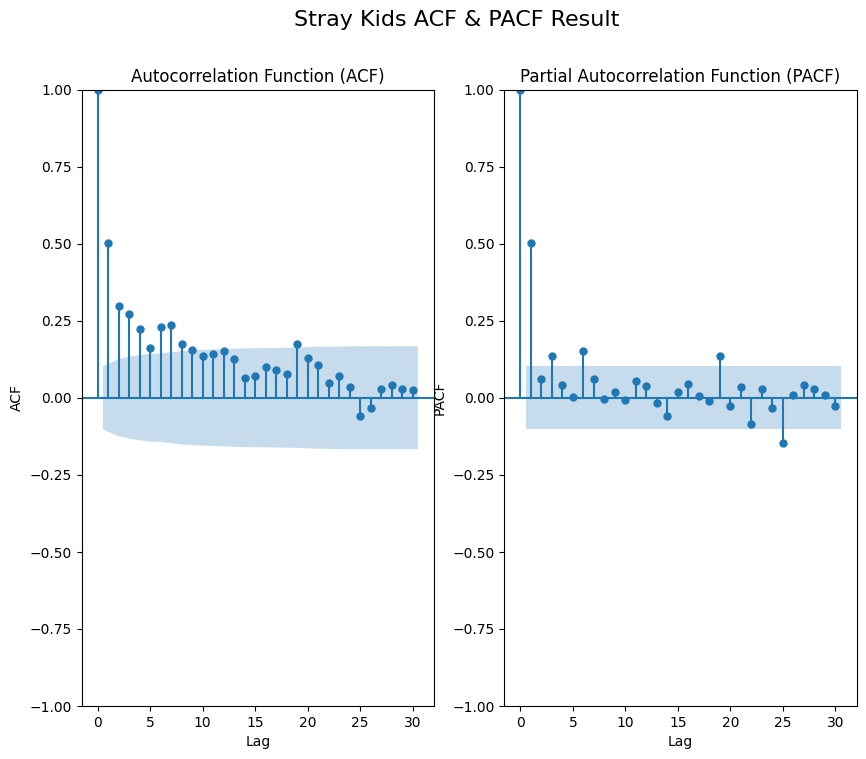

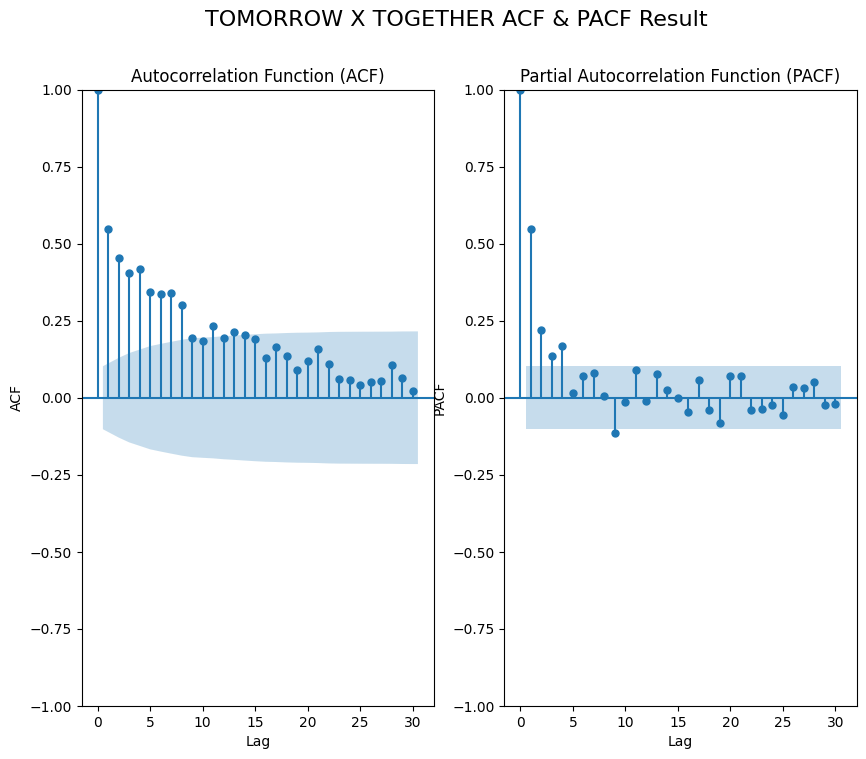

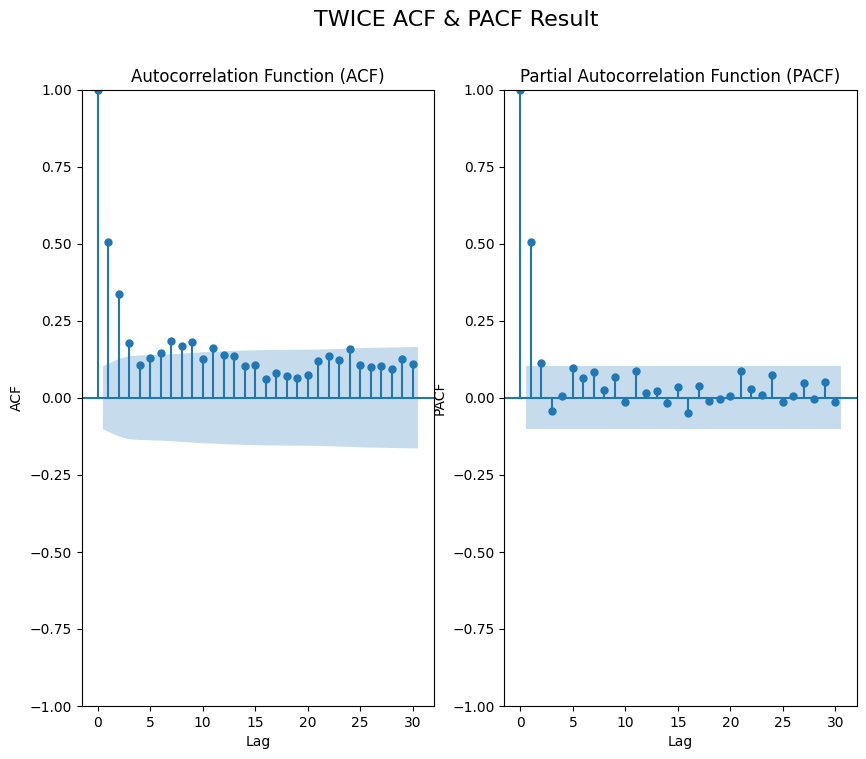

In [128]:
'''
  - ACF, PACF 검정
'''
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist].query("date >= '2023-06-30'")['trend2']

    # lag_num = np.round(len(trend_df) / 4) # 전체 시간의 4분의 1
    lag_num = 30

    # 시계열 데이터 생성 (예: 누적 합계로 단위근을 포함한 데이터)
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    plt.suptitle(f"{artist} ACF & PACF Result", fontsize=16)

    # ACF 시각화
    plot_acf(trend_df, lags=lag_num, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")

    # PACF 시각화
    plot_pacf(trend_df, lags=lag_num, method='ywm', ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")

    plt.show()

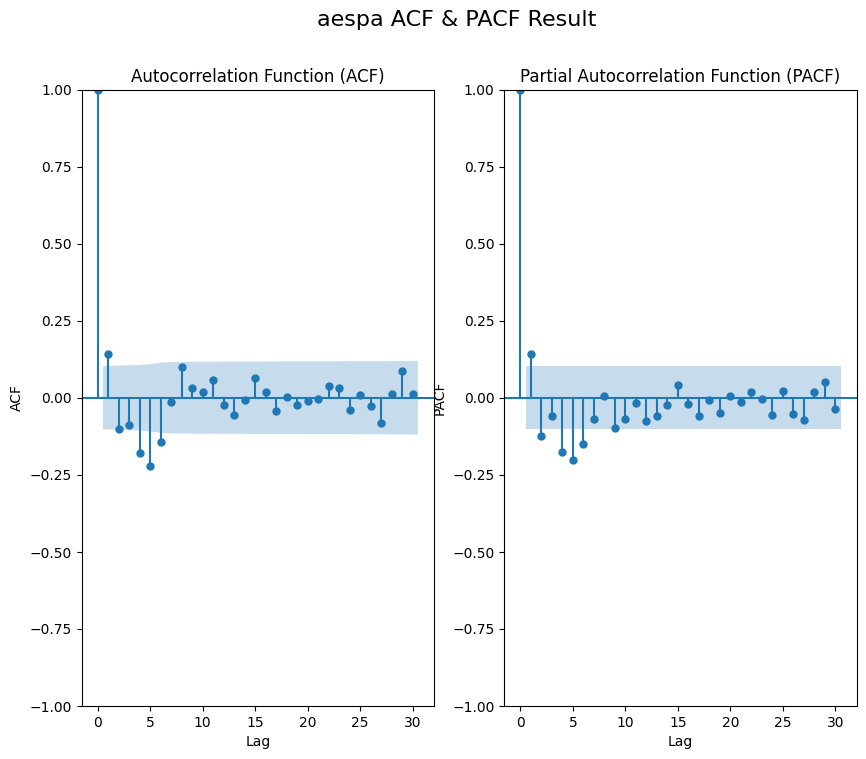

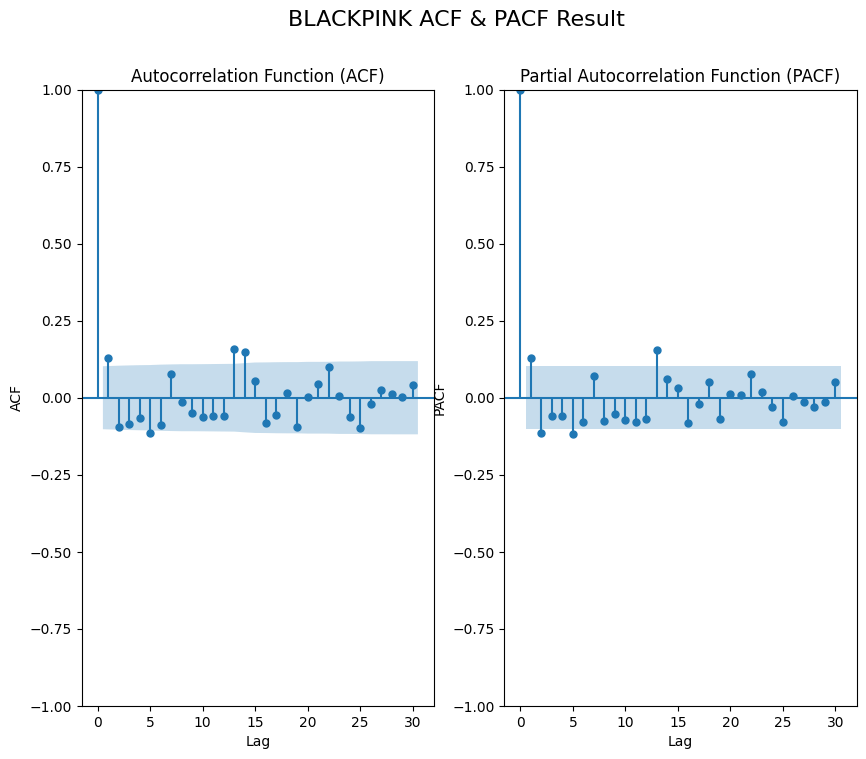

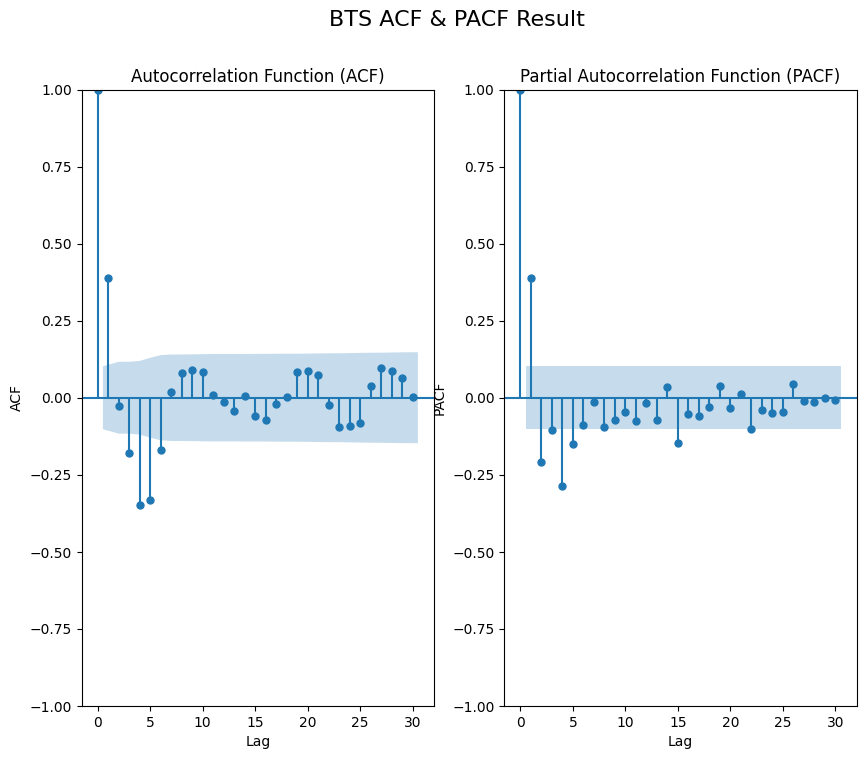

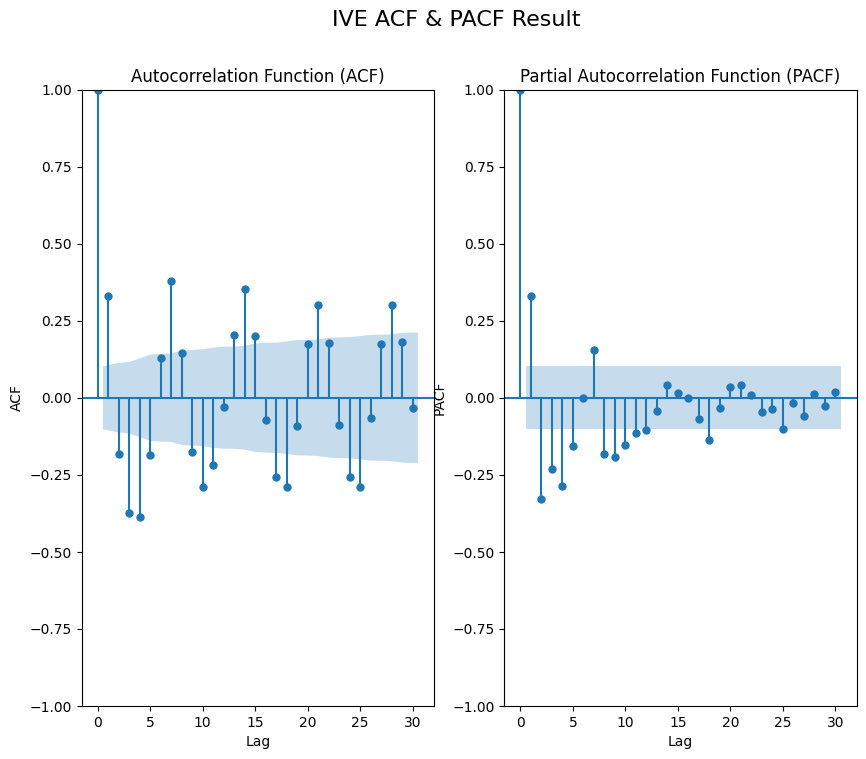

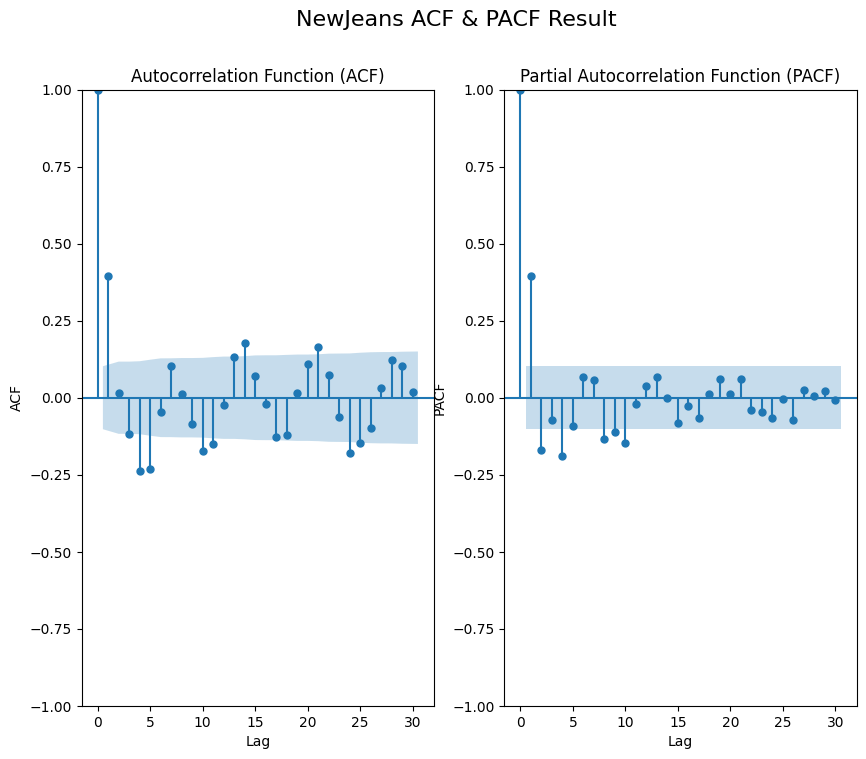

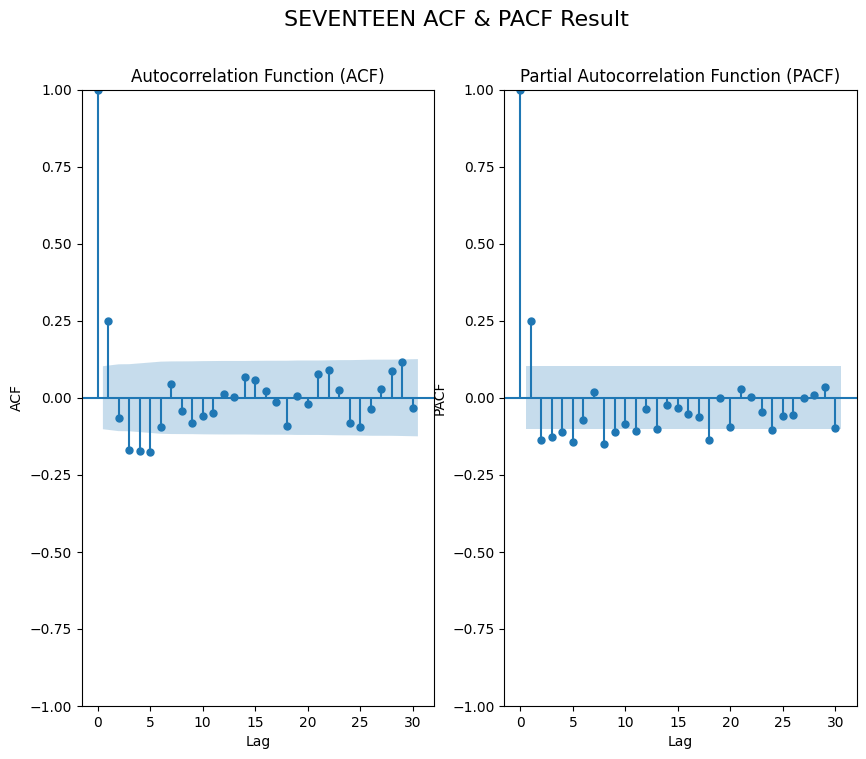

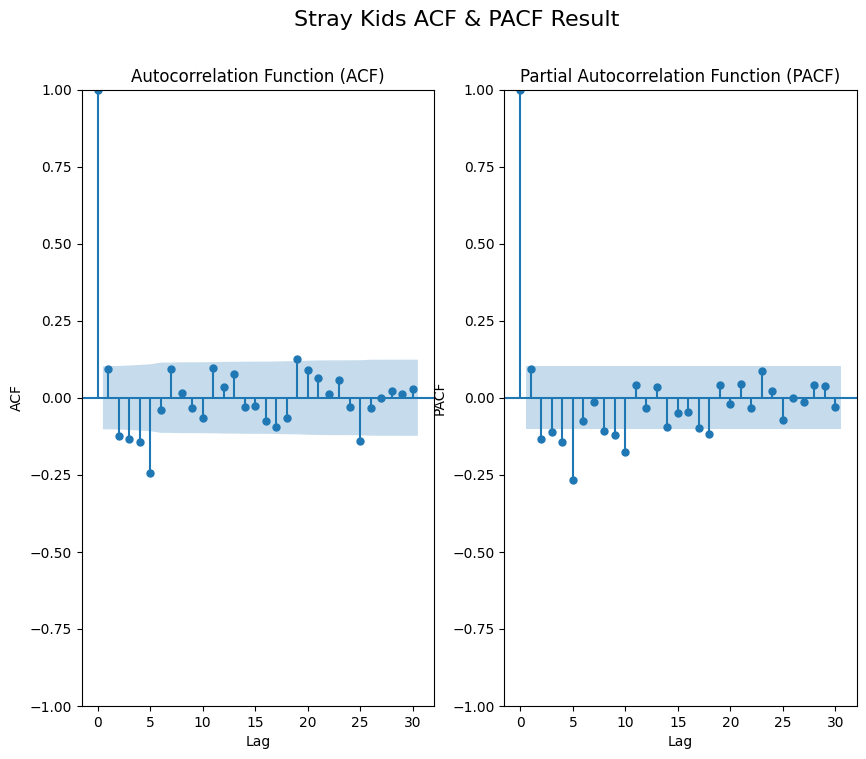

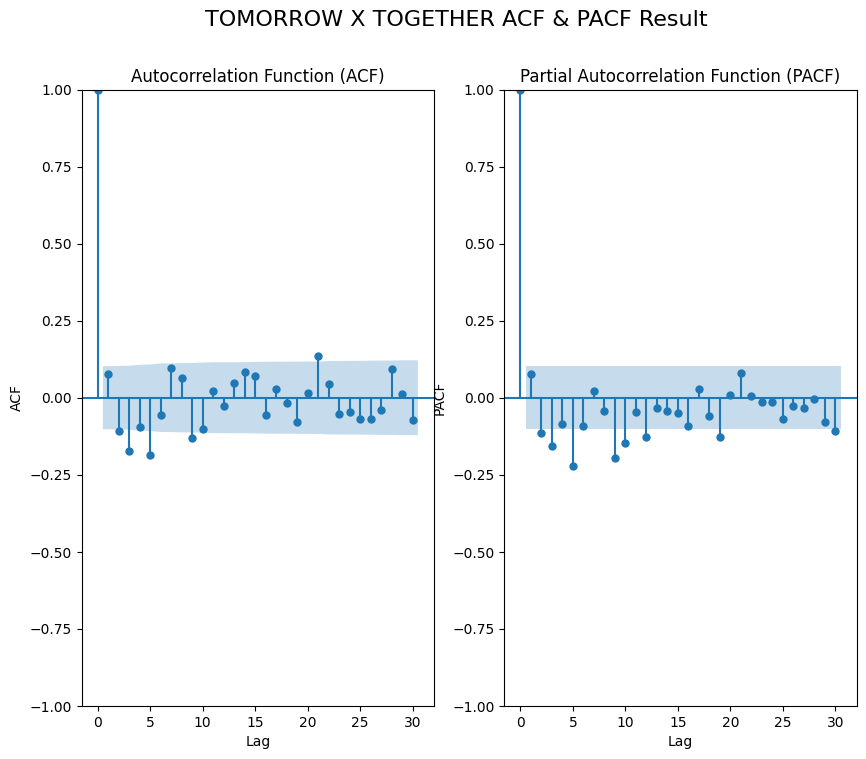

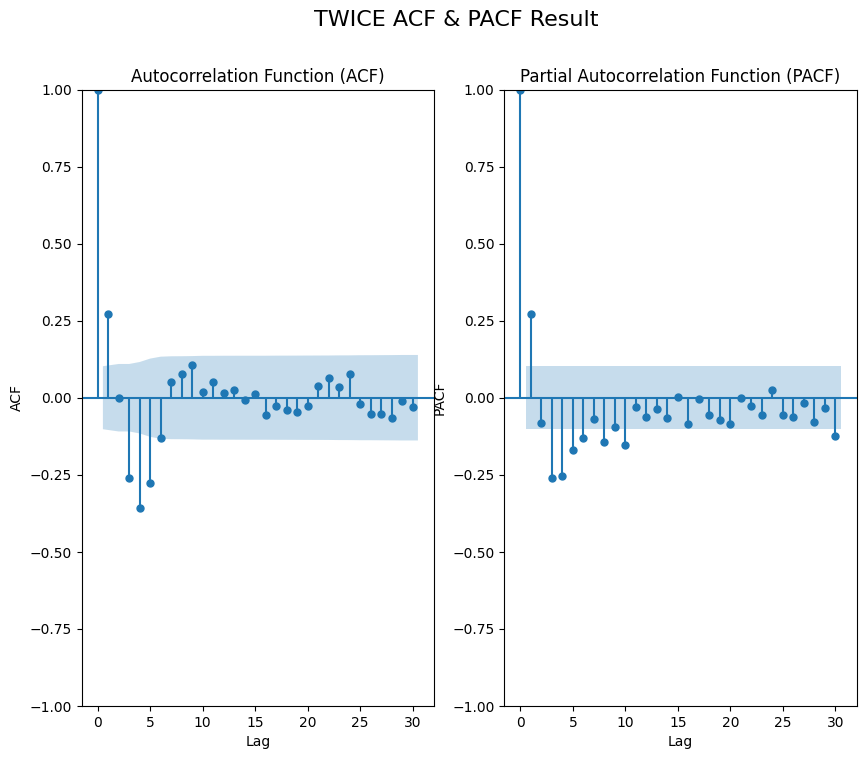

In [129]:
'''
  - 추세 제거한 trend ACF, PACF 검정
'''
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist].query("date >= '2023-06-30'")['trend3']

    # lag_num = np.round(len(trend_df) / 4) # 전체 시간의 4분의 1
    lag_num = 30

    # 시계열 데이터 생성 (예: 누적 합계로 단위근을 포함한 데이터)
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    plt.suptitle(f"{artist} ACF & PACF Result", fontsize=16)

    # ACF 시각화
    plot_acf(trend_df, lags=lag_num, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")

    # PACF 시각화
    plot_pacf(trend_df, lags=lag_num, method='ywm', ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")

    plt.show()

# AR 모델
* lag 값 4로 설정

In [ ]:
# ACF, PACF 검정 결과 기반으로 AR(4) 모델 구현
# 정상성 데이터 변환 전
from statsmodels.tsa.ar_model import AutoReg

forecast_df_list = []
for artist in google_trend_df2['artist'].unique():

    artist_trend_df = google_trend_df2[google_trend_df2['artist'] == artist].reset_index(drop=True)

    start_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] - pd.DateOffset(years=1) # 아티스트 별 수집 마지막 기간으로부터 이전 1년 데이터만 사용
    # start_date = google_trend_df2[google_trend_df2['artist'] == artist].reset_index(drop=True).loc[0, 'date'] # 아티스트 별 수집 첫 기간부터 적용

    trend_df = artist_trend_df[artist_trend_df['date'] >= start_date].reset_index(drop=True)['trend3']

    # AR(4) 모델 적합
    model = AutoReg(trend_df, lags=4)
    model_fit = model.fit()

    # 모델 예측
    end_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] + pd.DateOffset(days=30) # 이후 한 달 예측

    date_df = pd.date_range(start=start_date, end=end_date, freq='D')
    date_df = pd.DataFrame(date_df, columns=['date'])

    end = len(trend_df) + 30  # 30-step ahead forecast
    forecast_df = model_fit.predict(start=0, end=end)

    result_df = pd.concat([date_df, forecast_df], axis=1).merge(google_trend_df2[google_trend_df2['artist'] == artist][['date', 'trend2']], how='left', on='date')
    result_df.columns = ['date', 'forecast', 'origin']

    result_df['artist'] = artist

    forecast_df_list.append(result_df)

forecast_df = pd.concat(forecast_df_list, ignore_index=True)
forecast_df

date  forecast    origin artist
0    2023-06-30       NaN -7.416667  aespa
1    2023-07-01       NaN  0.791667  aespa
2    2023-07-02       NaN -6.375000  aespa
3    2023-07-03       NaN -0.625000  aespa
4    2023-07-04  1.976011 -5.166667  aespa
...         ...       ...       ...    ...
3577 2024-07-27 -0.032423       NaN  TWICE
3578 2024-07-28 -0.050665       NaN  TWICE
3579 2024-07-29 -0.063336       NaN  TWICE
3580 2024-07-30 -0.065413       NaN  TWICE
3581        NaT -0.059259       NaN  TWICE

[3582 rows x 4 columns]

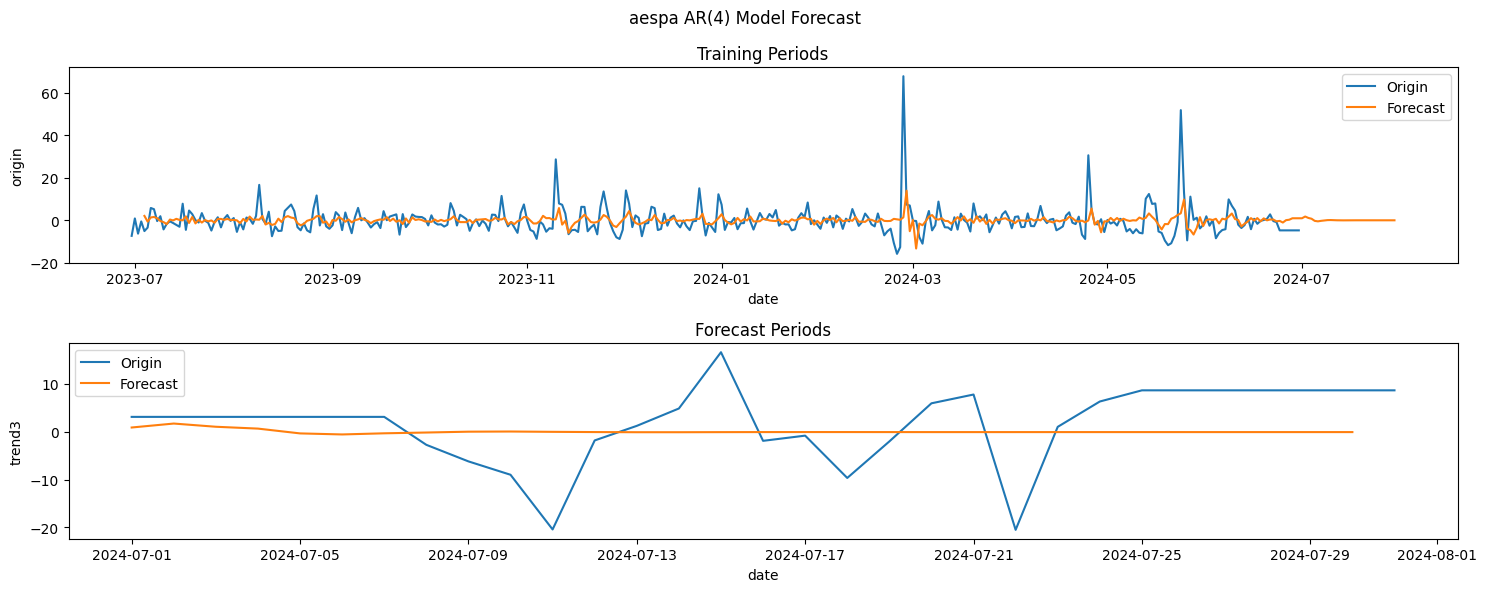

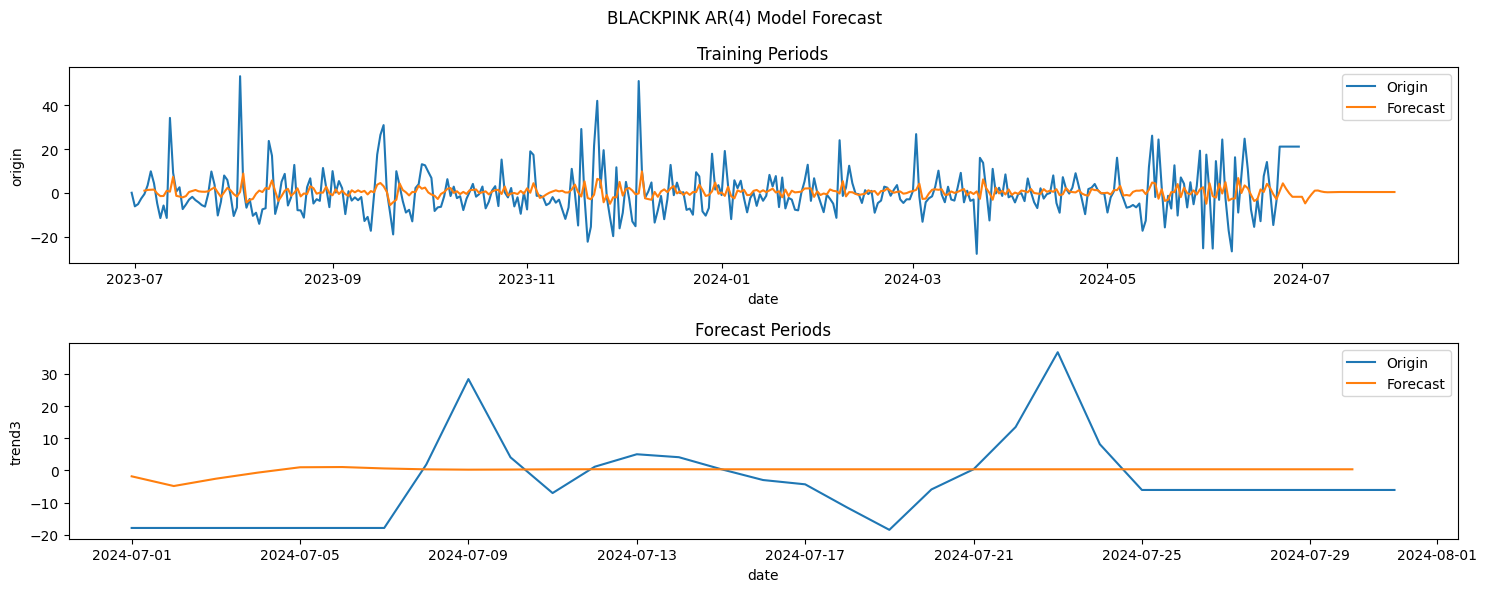

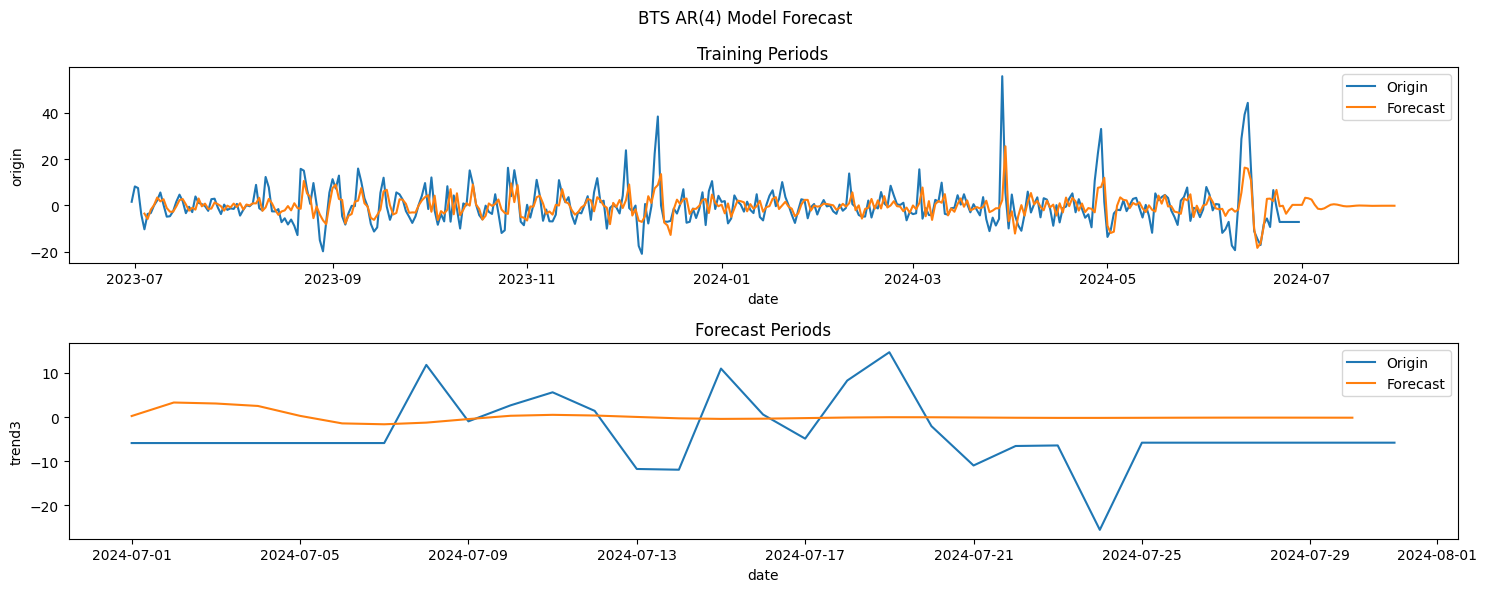

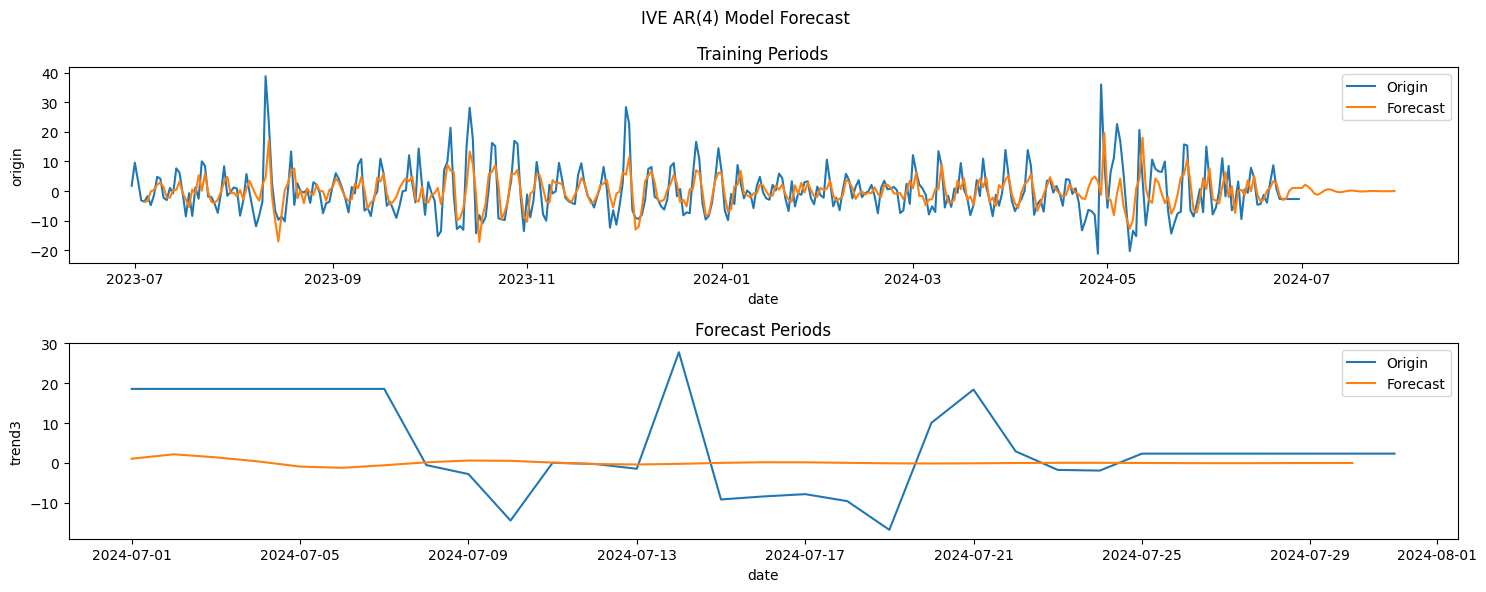

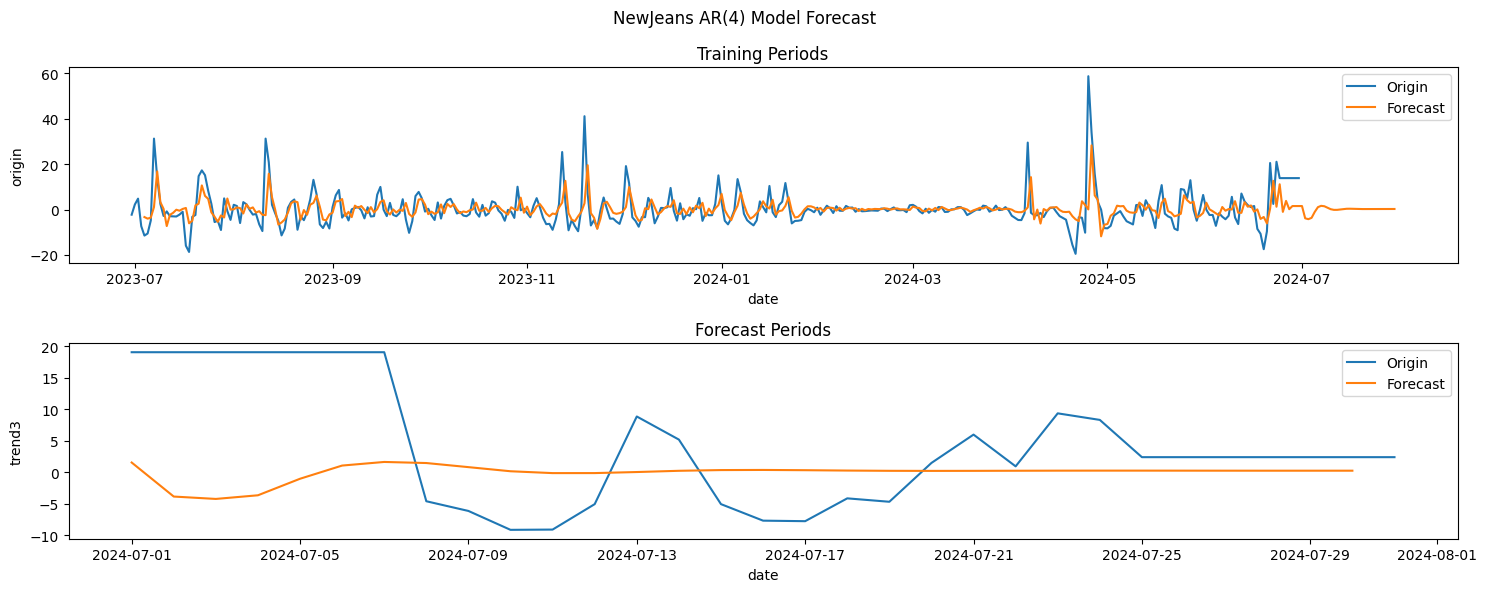

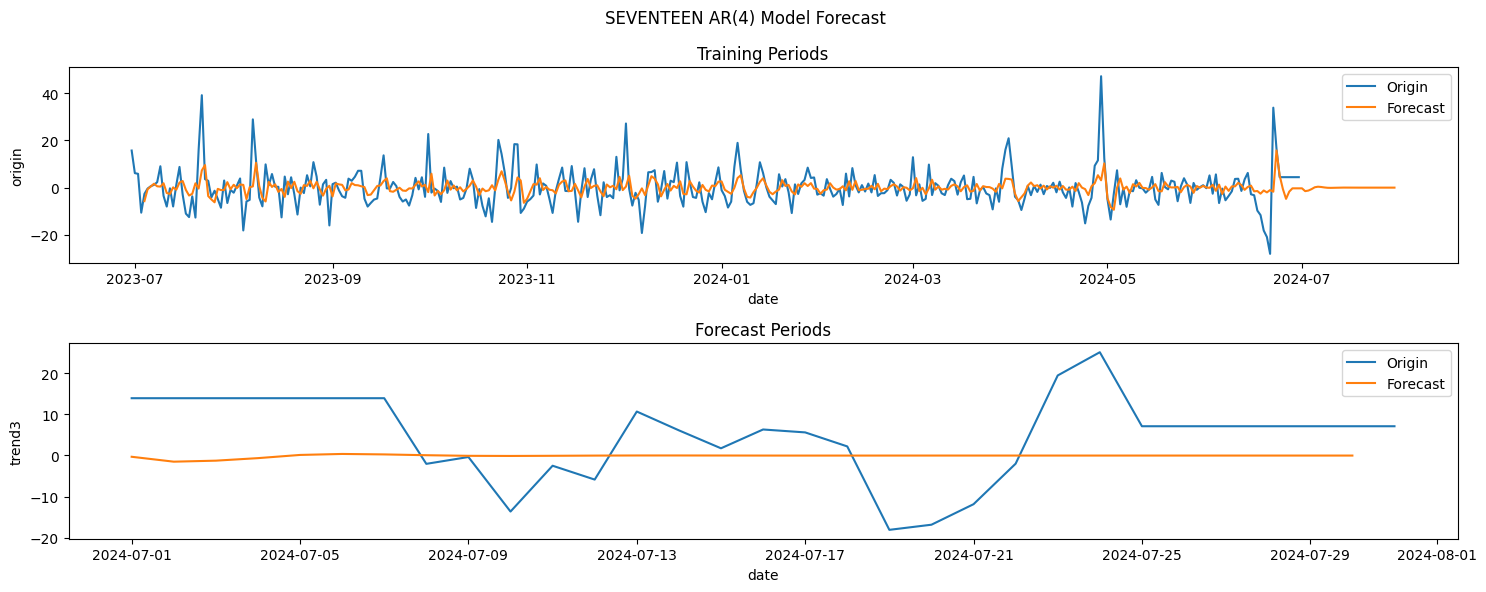

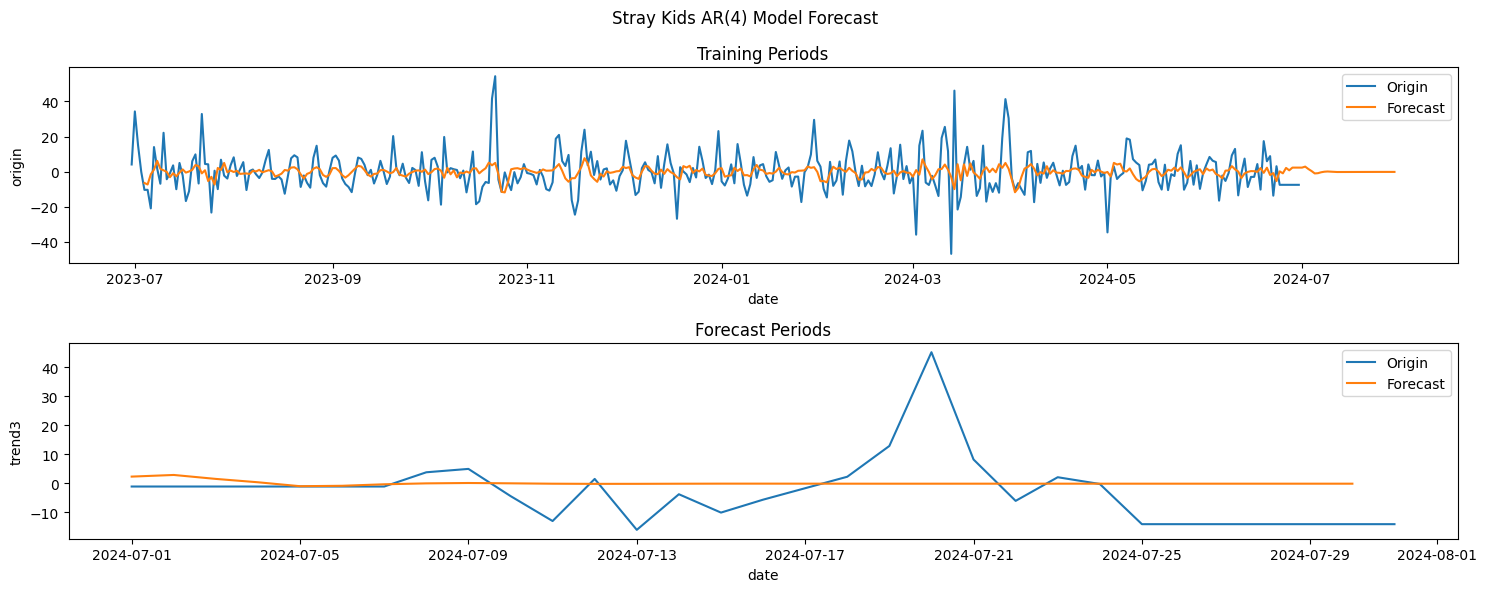

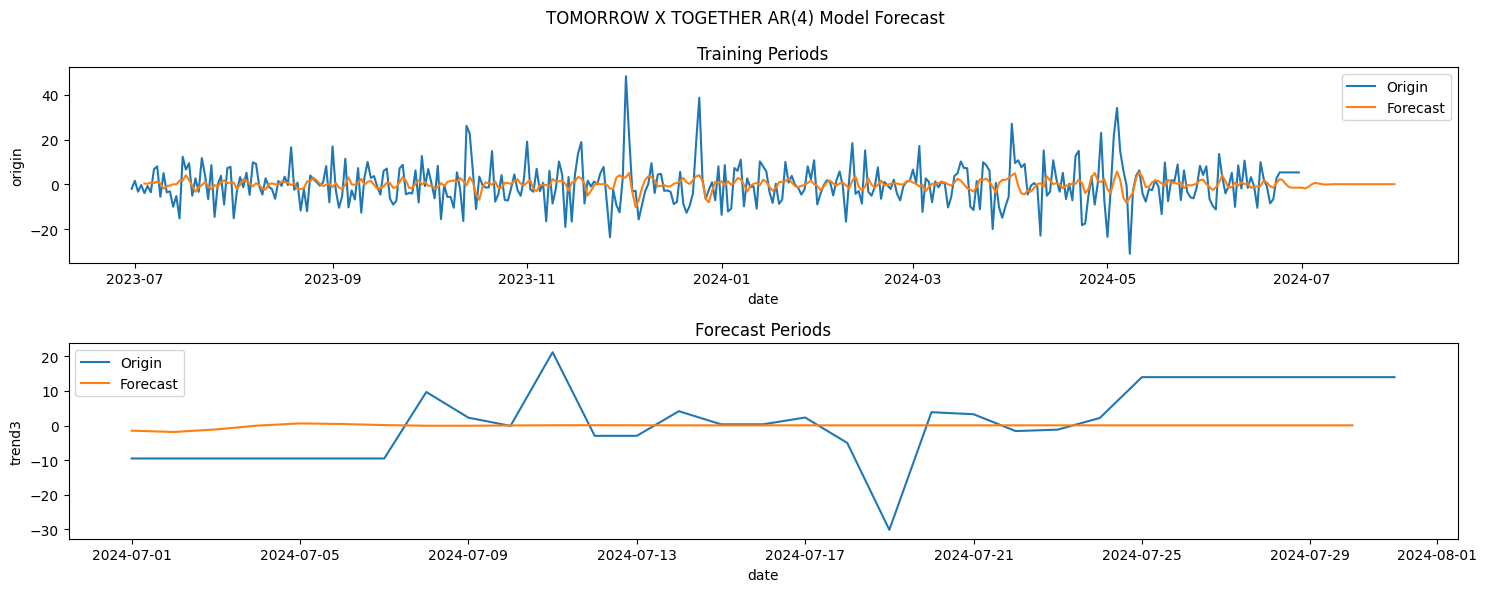

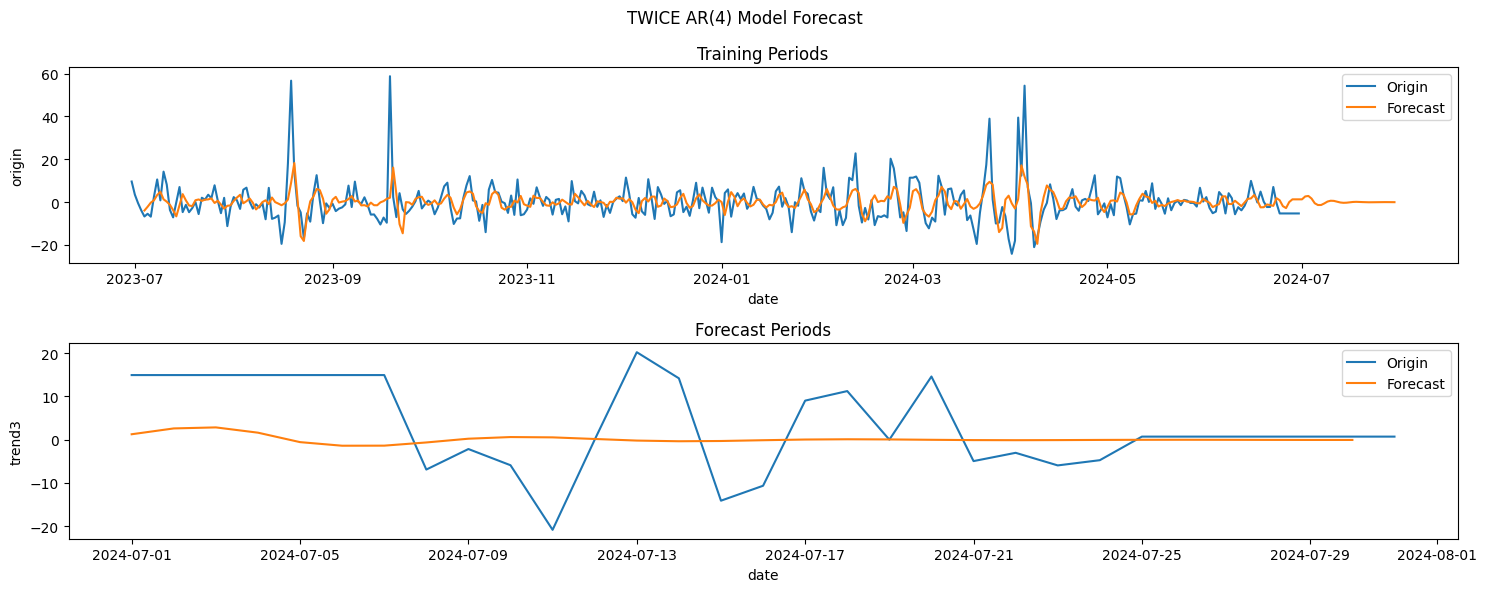

In [167]:
# 예측 결과 시각화
# 단순 AR(2) 모델로는 test dataset에 대하여 거의 맞추지 못함
for artist in forecast_df['artist'].unique():

    fig, axes = plt.subplots(2, 1, figsize=(15, 6))
    plt.suptitle(f'{artist} AR(4) Model Forecast')

    axes[0].set_title('Training Periods')
    sns.lineplot(data=forecast_df[forecast_df['artist'] == artist], x='date', y='origin', label='Origin', ax=axes[0])
    sns.lineplot(data=forecast_df[forecast_df['artist'] == artist], x='date', y='forecast', label='Forecast', ax=axes[0])

    axes[1].set_title('Forecast Periods')
    sns.lineplot(data=google_trend_test_df2[google_trend_test_df2['artist'] == artist], x='date', y='trend3', label='Origin', ax=axes[1])
    sns.lineplot(data=forecast_df[forecast_df['artist'] == artist].query("date >= '2024-07-01'"), x='date', y='forecast', label='Forecast', ax=axes[1])

    plt.legend()
    plt.tight_layout()

    plt.show()

# SARIMAX 모델
* 외부요인: 앨범 발매 정보 추가

In [136]:
album_info_df = artist_info_df.drop(['main_genre', 'sub_genre'], axis=1)[['album_name', 'album_type', 'artist_name', 'release_date', 'track_cnt', 'avg_track_play_time']].drop_duplicates()
album_info_df['release_date'] = pd.to_datetime(album_info_df['release_date'])

album_info_df = album_info_df[album_info_df['artist_name'] != 'NCT DREAM']

album_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 0 to 4715
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   album_name           220 non-null    object        
 1   album_type           220 non-null    object        
 2   artist_name          220 non-null    object        
 3   release_date         220 non-null    datetime64[ns]
 4   track_cnt            220 non-null    int64         
 5   avg_track_play_time  210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 12.0+ KB


In [137]:
# 앨범 수록곡 평균 재생 길이 null 값 제거
album_info_df = album_info_df[album_info_df['avg_track_play_time'].isnull() == False]
album_info_df

album_name album_type artist_name release_date  \
0                     LOVE & LETTER      Album   SEVENTEEN   2016-04-25   
8                         TEEN, AGE      Album   SEVENTEEN   2017-11-06   
16                           An Ode      Album   SEVENTEEN   2019-09-16   
24                     Face the Sun      Album   SEVENTEEN   2022-05-27   
32                          17 HITS      Album   SEVENTEEN   2016-10-21   
...                             ...        ...         ...          ...   
4219       You Never Know -JP ver.-     Single   BLACKPINK   2021-08-03   
4343                     Pink Venom     Single   BLACKPINK   2022-08-19   
4467                      THE GIRLS     Single   BLACKPINK   2023-08-25   
4591   SO HOT (THEBLACKLABEL remix)     Single   BLACKPINK   2017-12-25   
4715  DDU‐DU DDU‐DU (remix JP ver.)     Single   BLACKPINK   2019-10-16   

      track_cnt  avg_track_play_time  
0            10        198800.000000  
8            13        179153.846154  
16           11        195363.636364  
24            9        194044.111111  
32           16        196562.500000  
...         ...                  ...  
4219          1        229236.000000  
4343          1        186000.000000  
4467          1        162000.000000  
4591          1        155000.000000  
4715          1        201225.000000  

[210 rows x 6 columns]

In [139]:
# training google trend 와 병합
google_trend_album_df = google_trend_df2.merge(album_info_df, how='left', left_on=['artist', 'date'], right_on=['artist_name', 'release_date']).drop('artist_name', axis=1)
google_trend_album_df

date  trend artist    trend3  trend2 album_name album_type  \
0     2020-10-25    NaN  aespa  0.000000     8.0        NaN        NaN   
1     2020-10-26    NaN  aespa  0.000000     8.0        NaN        NaN   
2     2020-10-27    NaN  aespa  0.000000     8.0        NaN        NaN   
3     2020-10-28    NaN  aespa  0.000000     8.0        NaN        NaN   
4     2020-10-29    NaN  aespa  0.000000     8.0        NaN        NaN   
...          ...    ...    ...       ...     ...        ...        ...   
14625 2024-06-26   24.0  TWICE -5.333333    24.0        NaN        NaN   
14626 2024-06-27   23.0  TWICE -5.333333    23.0        NaN        NaN   
14627 2024-06-28   20.0  TWICE -5.333333    20.0        NaN        NaN   
14628 2024-06-29   34.0  TWICE -5.333333    34.0        NaN        NaN   
14629 2024-06-30   30.0  TWICE -5.333333    30.0        NaN        NaN   

      release_date  track_cnt  avg_track_play_time  
0              NaT        NaN                  NaN  
1              NaT        NaN                  NaN  
2              NaT        NaN                  NaN  
3              NaT        NaN                  NaN  
4              NaT        NaN                  NaN  
...            ...        ...                  ...  
14625          NaT        NaN                  NaN  
14626          NaT        NaN                  NaN  
14627          NaT        NaN                  NaN  
14628          NaT        NaN                  NaN  
14629          NaT        NaN                  NaN  

[14630 rows x 10 columns]

In [140]:
# 앨범 발매일 이후 7일 동일 데이터 적용
# 앨범 초동 판매량 집계 기준일에 따라 7일 적용
for i, row in google_trend_album_df.iterrows():

    artist = row['artist']
    release_date = row['release_date']
    end_date = release_date + pd.Timedelta(days=7)  # 발매일 이후 7일

    # 해당 기간에 데이터 할당
    mask = (google_trend_album_df['artist'] == artist) & \
           (google_trend_album_df['date'] >= release_date) & (google_trend_album_df['date'] < end_date)

    google_trend_album_df.loc[mask, 'release_date'] = row['release_date']
    google_trend_album_df.loc[mask, 'album_name'] = row['album_name']
    google_trend_album_df.loc[mask, 'album_type'] = row['album_type']

    google_trend_album_df.loc[mask, 'track_cnt'] = row['track_cnt']
    google_trend_album_df.loc[mask, 'avg_track_play_time'] = row['avg_track_play_time']

google_trend_album_df[google_trend_album_df['album_name'].isnull() == False]

date  trend artist     trend3  trend2   album_name album_type  \
23    2020-11-17   37.0  aespa   7.833333    37.0  Black Mamba     Single   
24    2020-11-18   36.0  aespa   1.208333    36.0  Black Mamba     Single   
25    2020-11-19   27.0  aespa -12.500000    27.0  Black Mamba     Single   
26    2020-11-20   41.0  aespa  -2.541667    41.0  Black Mamba     Single   
27    2020-11-21   31.0  aespa -16.750000    31.0  Black Mamba     Single   
...          ...    ...    ...        ...     ...          ...        ...   
14410 2023-11-24   31.0  TWICE   0.791667    31.0  THE REMIXES      Album   
14411 2023-11-25   23.0  TWICE  -6.958333    23.0  THE REMIXES      Album   
14412 2023-11-26   29.0  TWICE  -1.333333    29.0  THE REMIXES      Album   
14413 2023-11-27   26.0  TWICE  -5.083333    26.0  THE REMIXES      Album   
14414 2023-11-28   31.0  TWICE   0.041667    31.0  THE REMIXES      Album   

      release_date  track_cnt  avg_track_play_time  
23      2020-11-17        1.0        174933.000000  
24      2020-11-17        1.0        174933.000000  
25      2020-11-17        1.0        174933.000000  
26      2020-11-17        1.0        174933.000000  
27      2020-11-17        1.0        174933.000000  
...            ...        ...                  ...  
14410   2023-11-22        7.0        183437.142857  
14411   2023-11-22        7.0        183437.142857  
14412   2023-11-22        7.0        183437.142857  
14413   2023-11-22        7.0        183437.142857  
14414   2023-11-22        7.0        183437.142857  

[1002 rows x 10 columns]

In [141]:
# 앨범 장르 인코딩
encoded_album_type_df = pd.get_dummies(google_trend_album_df['album_type'])
google_trend_album_df = pd.concat([google_trend_album_df, encoded_album_type_df], axis=1)

# 모든 bool 타입 열을 1/0으로 변환
google_trend_album_df = google_trend_album_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

google_trend_album_df

date  trend artist    trend3  trend2 album_name album_type  \
0     2020-10-25    NaN  aespa  0.000000     8.0        NaN        NaN   
1     2020-10-26    NaN  aespa  0.000000     8.0        NaN        NaN   
2     2020-10-27    NaN  aespa  0.000000     8.0        NaN        NaN   
3     2020-10-28    NaN  aespa  0.000000     8.0        NaN        NaN   
4     2020-10-29    NaN  aespa  0.000000     8.0        NaN        NaN   
...          ...    ...    ...       ...     ...        ...        ...   
14625 2024-06-26   24.0  TWICE -5.333333    24.0        NaN        NaN   
14626 2024-06-27   23.0  TWICE -5.333333    23.0        NaN        NaN   
14627 2024-06-28   20.0  TWICE -5.333333    20.0        NaN        NaN   
14628 2024-06-29   34.0  TWICE -5.333333    34.0        NaN        NaN   
14629 2024-06-30   30.0  TWICE -5.333333    30.0        NaN        NaN   

      release_date  track_cnt  avg_track_play_time  Album  Broadcast  EP  \
0              NaT        NaN                  NaN      0          0   0   
1              NaT        NaN                  NaN      0          0   0   
2              NaT        NaN                  NaN      0          0   0   
3              NaT        NaN                  NaN      0          0   0   
4              NaT        NaN                  NaN      0          0   0   
...            ...        ...                  ...    ...        ...  ..   
14625          NaT        NaN                  NaN      0          0   0   
14626          NaT        NaN                  NaN      0          0   0   
14627          NaT        NaN                  NaN      0          0   0   
14628          NaT        NaN                  NaN      0          0   0   
14629          NaT        NaN                  NaN      0          0   0   

       Other  Single  
0          0       0  
1          0       0  
2          0       0  
3          0       0  
4          0       0  
...      ...     ...  
14625      0       0  
14626      0       0  
14627      0       0  
14628      0       0  
14629      0       0  

[14630 rows x 15 columns]

In [142]:
google_trend_album_df = google_trend_album_df.drop(['album_type'], axis=1)
google_trend_album_df

date  trend artist    trend3  trend2 album_name release_date  \
0     2020-10-25    NaN  aespa  0.000000     8.0        NaN          NaT   
1     2020-10-26    NaN  aespa  0.000000     8.0        NaN          NaT   
2     2020-10-27    NaN  aespa  0.000000     8.0        NaN          NaT   
3     2020-10-28    NaN  aespa  0.000000     8.0        NaN          NaT   
4     2020-10-29    NaN  aespa  0.000000     8.0        NaN          NaT   
...          ...    ...    ...       ...     ...        ...          ...   
14625 2024-06-26   24.0  TWICE -5.333333    24.0        NaN          NaT   
14626 2024-06-27   23.0  TWICE -5.333333    23.0        NaN          NaT   
14627 2024-06-28   20.0  TWICE -5.333333    20.0        NaN          NaT   
14628 2024-06-29   34.0  TWICE -5.333333    34.0        NaN          NaT   
14629 2024-06-30   30.0  TWICE -5.333333    30.0        NaN          NaT   

       track_cnt  avg_track_play_time  Album  Broadcast  EP  Other  Single  
0            NaN                  NaN      0          0   0      0       0  
1            NaN                  NaN      0          0   0      0       0  
2            NaN                  NaN      0          0   0      0       0  
3            NaN                  NaN      0          0   0      0       0  
4            NaN                  NaN      0          0   0      0       0  
...          ...                  ...    ...        ...  ..    ...     ...  
14625        NaN                  NaN      0          0   0      0       0  
14626        NaN                  NaN      0          0   0      0       0  
14627        NaN                  NaN      0          0   0      0       0  
14628        NaN                  NaN      0          0   0      0       0  
14629        NaN                  NaN      0          0   0      0       0  

[14630 rows x 14 columns]

In [143]:
# 최신 앨범 발매일 도달 기간
google_trend_album_df['release_duration'] = (google_trend_album_df['date'] - google_trend_album_df['release_date']).dt.days
google_trend_album_df

date  trend artist    trend3  trend2 album_name release_date  \
0     2020-10-25    NaN  aespa  0.000000     8.0        NaN          NaT   
1     2020-10-26    NaN  aespa  0.000000     8.0        NaN          NaT   
2     2020-10-27    NaN  aespa  0.000000     8.0        NaN          NaT   
3     2020-10-28    NaN  aespa  0.000000     8.0        NaN          NaT   
4     2020-10-29    NaN  aespa  0.000000     8.0        NaN          NaT   
...          ...    ...    ...       ...     ...        ...          ...   
14625 2024-06-26   24.0  TWICE -5.333333    24.0        NaN          NaT   
14626 2024-06-27   23.0  TWICE -5.333333    23.0        NaN          NaT   
14627 2024-06-28   20.0  TWICE -5.333333    20.0        NaN          NaT   
14628 2024-06-29   34.0  TWICE -5.333333    34.0        NaN          NaT   
14629 2024-06-30   30.0  TWICE -5.333333    30.0        NaN          NaT   

       track_cnt  avg_track_play_time  Album  Broadcast  EP  Other  Single  \
0            NaN                  NaN      0          0   0      0       0   
1            NaN                  NaN      0          0   0      0       0   
2            NaN                  NaN      0          0   0      0       0   
3            NaN                  NaN      0          0   0      0       0   
4            NaN                  NaN      0          0   0      0       0   
...          ...                  ...    ...        ...  ..    ...     ...   
14625        NaN                  NaN      0          0   0      0       0   
14626        NaN                  NaN      0          0   0      0       0   
14627        NaN                  NaN      0          0   0      0       0   
14628        NaN                  NaN      0          0   0      0       0   
14629        NaN                  NaN      0          0   0      0       0   

       release_duration  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
14625               NaN  
14626               NaN  
14627               NaN  
14628               NaN  
14629               NaN  

[14630 rows x 15 columns]

## 외부변수 미적용

In [145]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import pandas as pd

forecast_arima_df_list = []
for artist in tqdm(google_trend_album_df['artist'].unique()):

    artist_trend_df = google_trend_album_df[google_trend_album_df['artist'] == artist].reset_index(drop=True)

    # 아티스트 별 수집 마지막 기간으로부터 이전 1년 데이터만 사용
    start_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] - pd.DateOffset(years=1)

    trend_df = artist_trend_df[artist_trend_df['date'] >= start_date].reset_index(drop=True)[['date', 'trend3', 'release_duration', 'track_cnt', 'avg_track_play_time', 'Album', 'Broadcast', 'EP', 'Other', 'Single']]

    # ARIMA 모델 적합 (p, d, q 값은 ACF, PACF 결과를 기반으로 설정)
    model = SARIMAX(
        endog=trend_df['trend3'],
        order=(4, 1, 4),
        seasonal_order=(4, 1, 4, 12),
        # exog=['release_duration', 'track_cnt', 'avg_track_play_time', 'Album', 'Broadcast', 'EP', 'Other', 'Single']
    )  # (p, d, q)는 ACF, PACF 결과를 바탕으로 설정 필요
    model_fit = model.fit(disp=False)

    # 모델 예측
    forecast_days_num = 31 # 훈련 기간 이후 예측하고자 하는 일수
    end_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] + pd.DateOffset(days=forecast_days_num)  # 이후 한 달 예측

    date_df = pd.date_range(start=start_date, end=end_date, freq='D')
    date_df = pd.DataFrame(date_df, columns=['date'])

    predict_df = model_fit.get_prediction(start=trend_df.index[0], end=trend_df.index[-1]+forecast_days_num).predicted_mean # 훈련 기간 예측 결과 + 이후 한 달 forecast

    # 예측 결과를 DataFrame으로 결합
    result_df = pd.concat([date_df, predict_df], axis=1).merge(
        google_trend_df2[google_trend_df2['artist'] == artist][['date', 'trend3']],
        how='left',
        on='date'
    )
    result_df.columns = ['date', 'forecast', 'origin']

    result_df['artist'] = artist
    forecast_arima_df_list.append(result_df)

forecast_arima_df = pd.concat(forecast_arima_df_list, ignore_index=True)
forecast_arima_df

  0%|          | 0/9 [00:00<?, ?it/s]

date  forecast    origin artist
0    2023-06-30  0.000000 -7.416667  aespa
1    2023-07-01 -7.416461  0.791667  aespa
2    2023-07-02  0.791308 -6.375000  aespa
3    2023-07-03 -6.374794 -0.625000  aespa
4    2023-07-04 -0.625176 -5.166667  aespa
...         ...       ...       ...    ...
3581 2024-07-27  3.066605       NaN  TWICE
3582 2024-07-28  3.153749       NaN  TWICE
3583 2024-07-29  0.397206       NaN  TWICE
3584 2024-07-30 -3.125822       NaN  TWICE
3585 2024-07-31 -1.961420       NaN  TWICE

[3586 rows x 4 columns]

In [148]:
google_trend_test_df2

date  trend artist    trend3
0   2024-07-01     76  aespa  3.083333
1   2024-07-02     87  aespa  3.083333
2   2024-07-03    100  aespa  3.083333
3   2024-07-04     96  aespa  3.083333
4   2024-07-05     67  aespa  3.083333
..         ...    ...    ...       ...
274 2024-07-27     46  TWICE  0.708333
275 2024-07-28     50  TWICE  0.708333
276 2024-07-29     43  TWICE  0.708333
277 2024-07-30     47  TWICE  0.708333
278 2024-07-31    100  TWICE  0.708333

[279 rows x 4 columns]

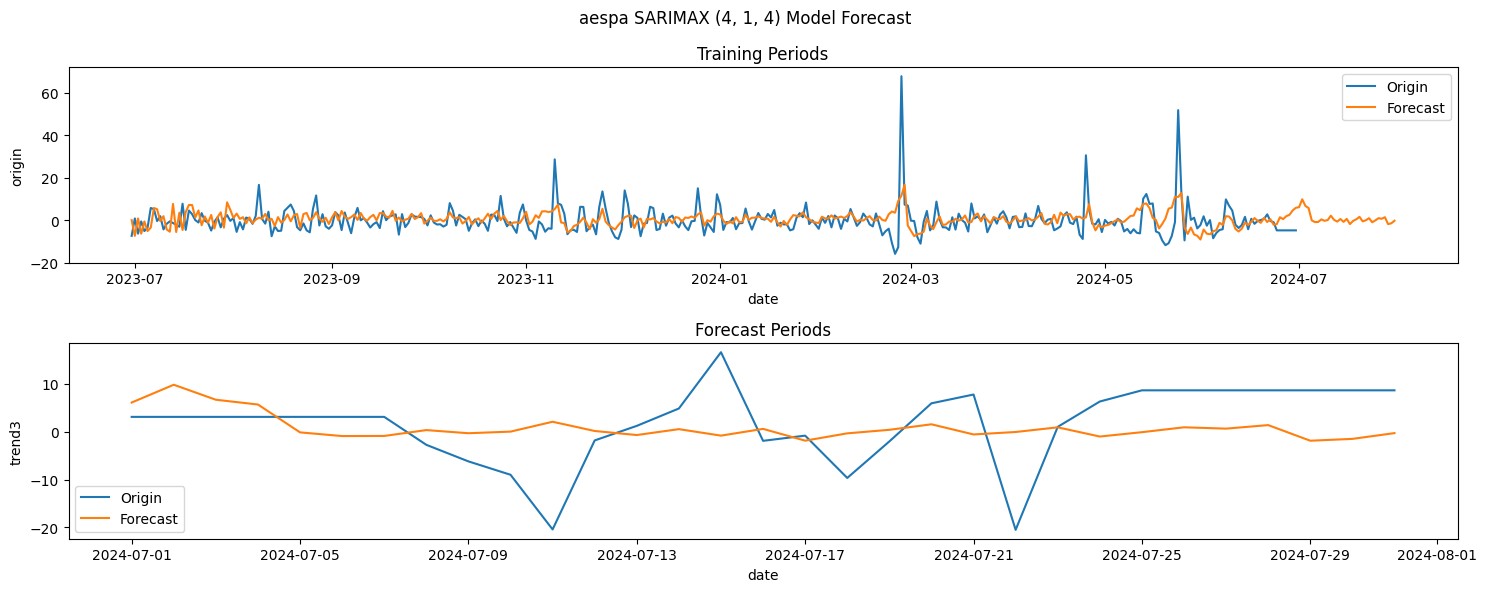

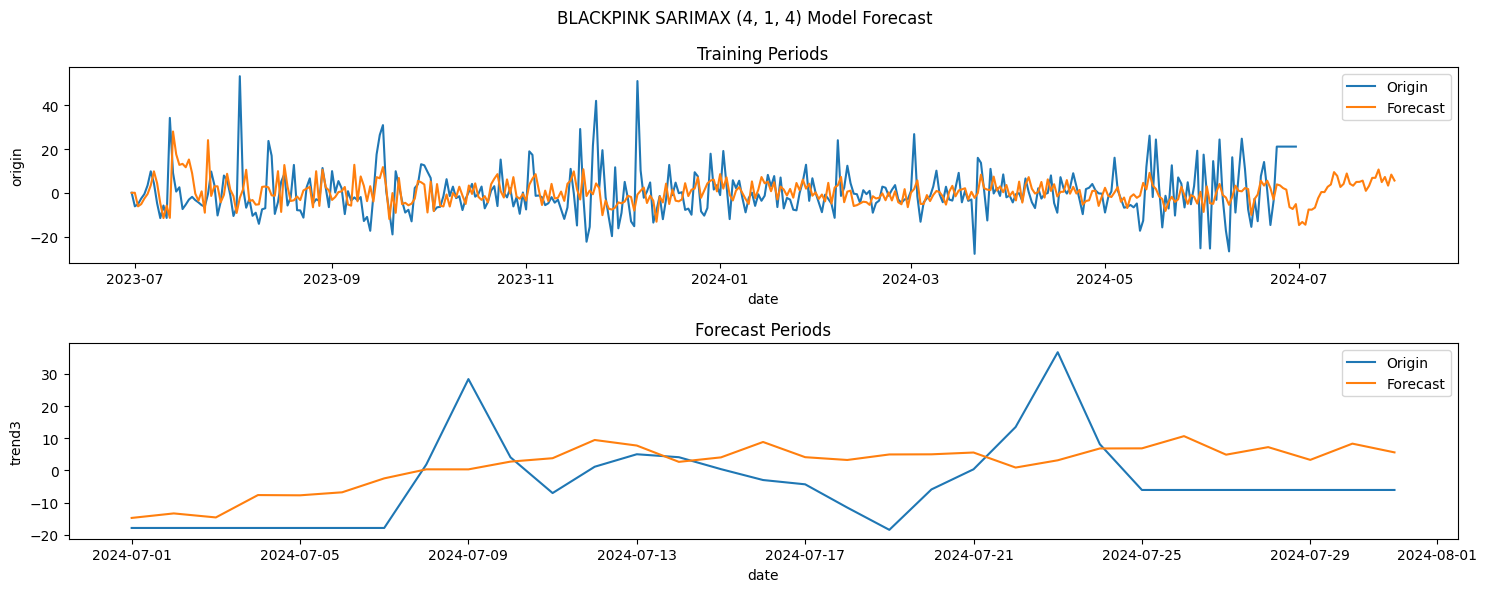

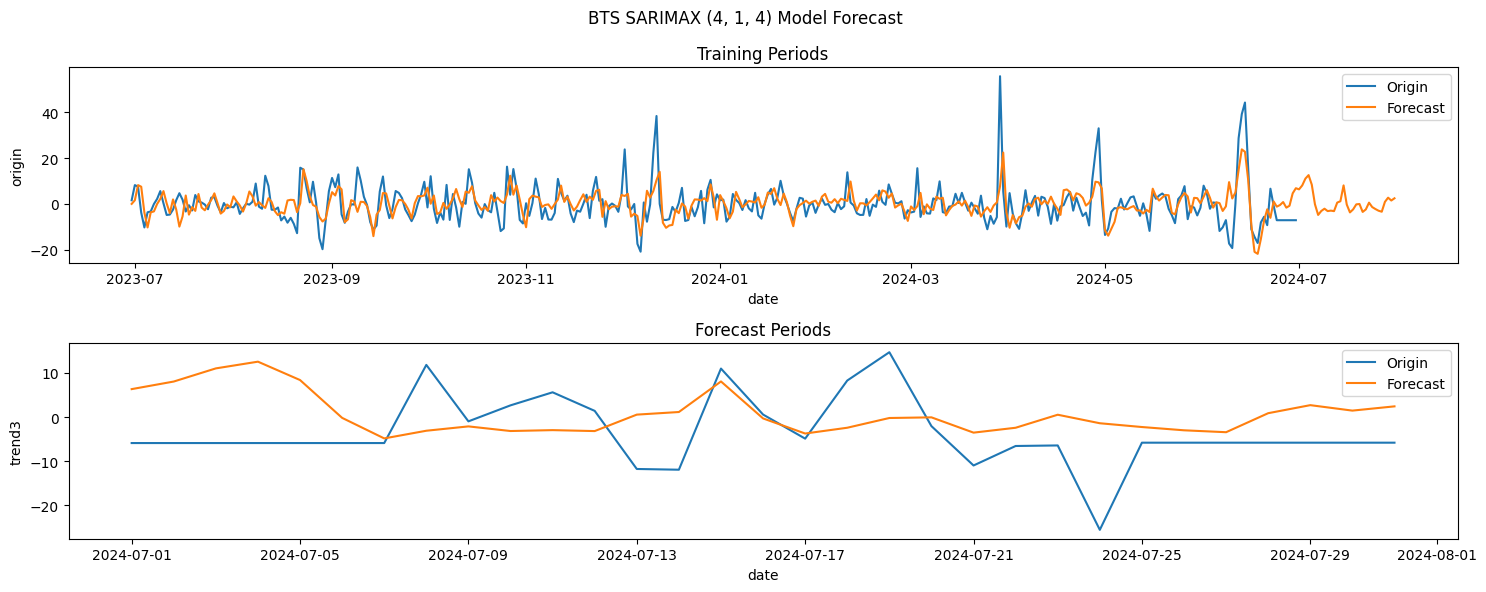

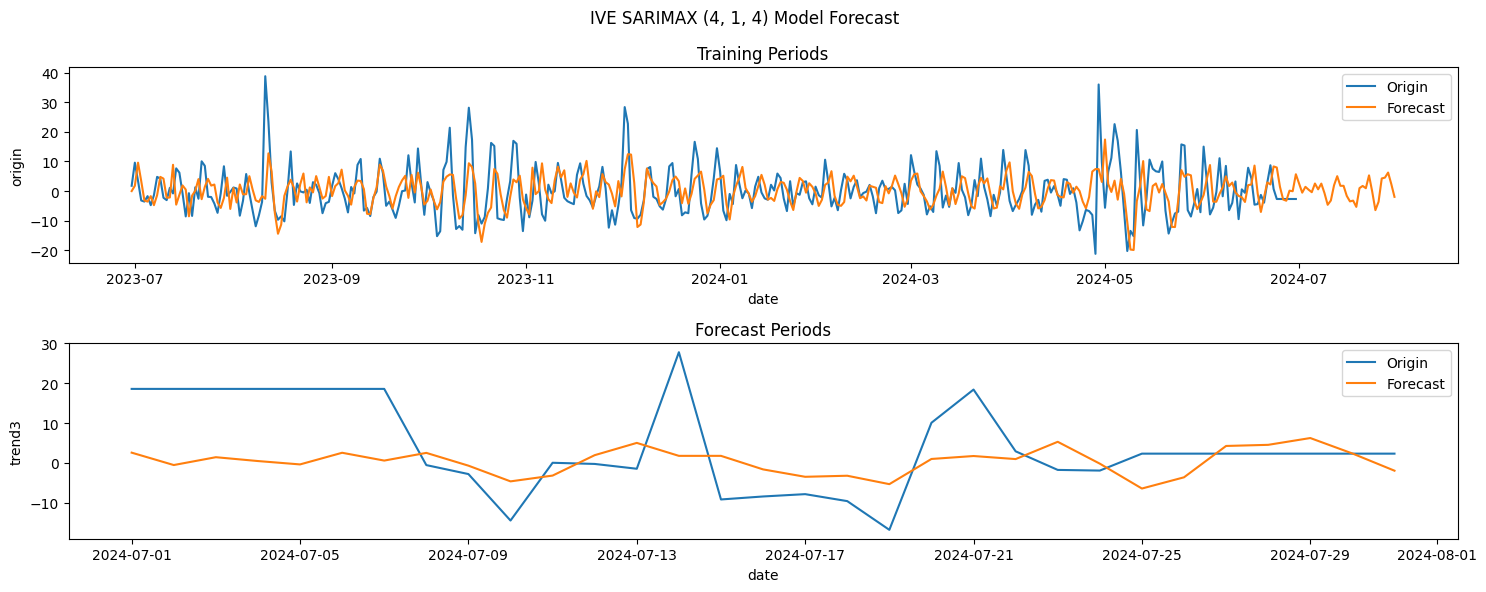

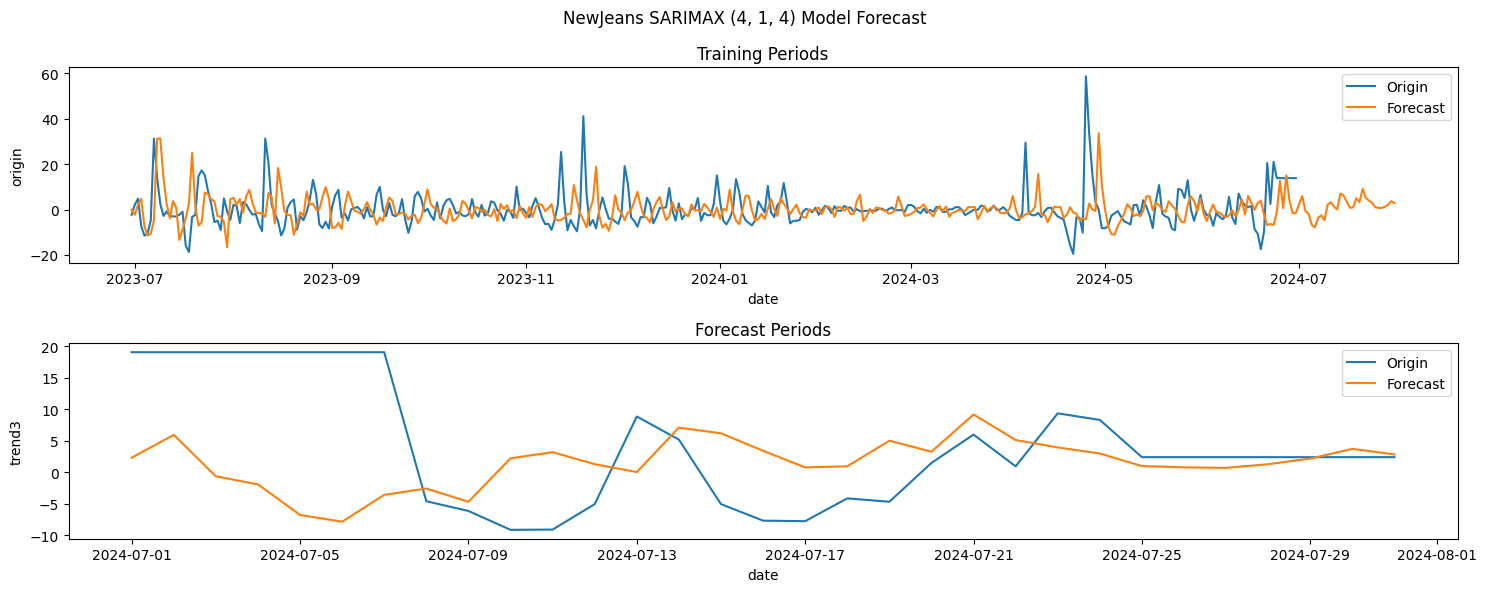

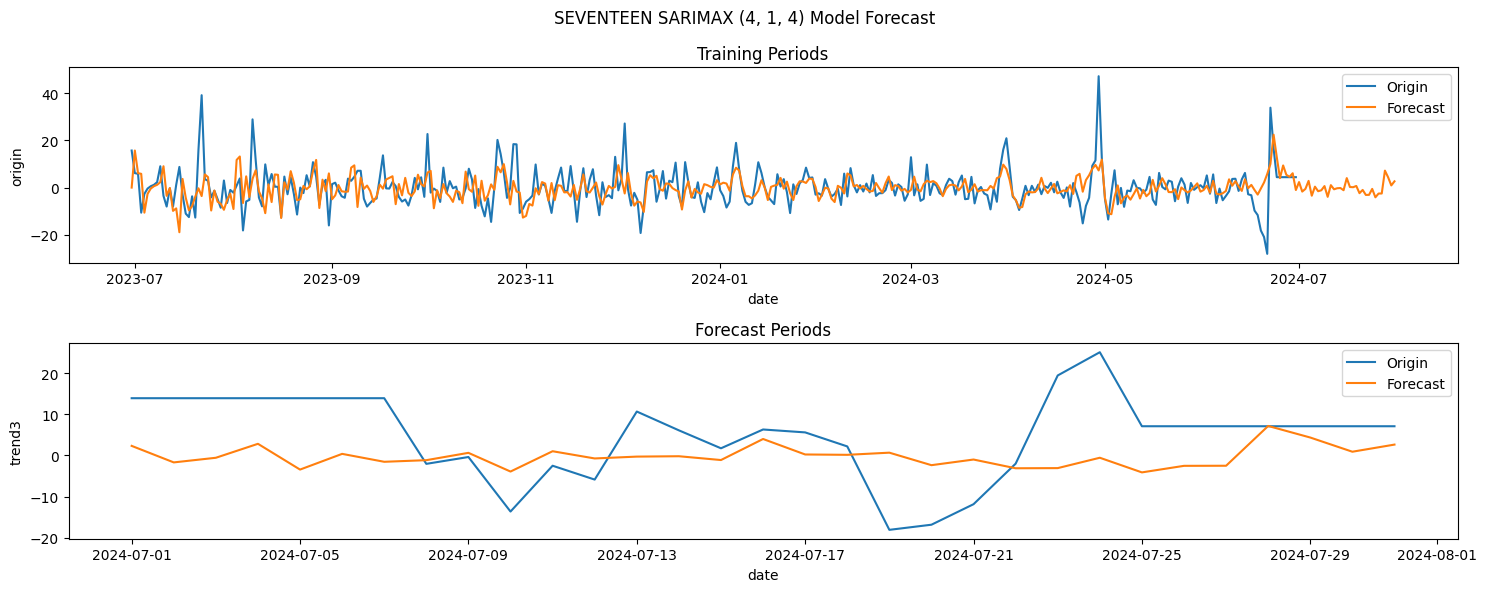

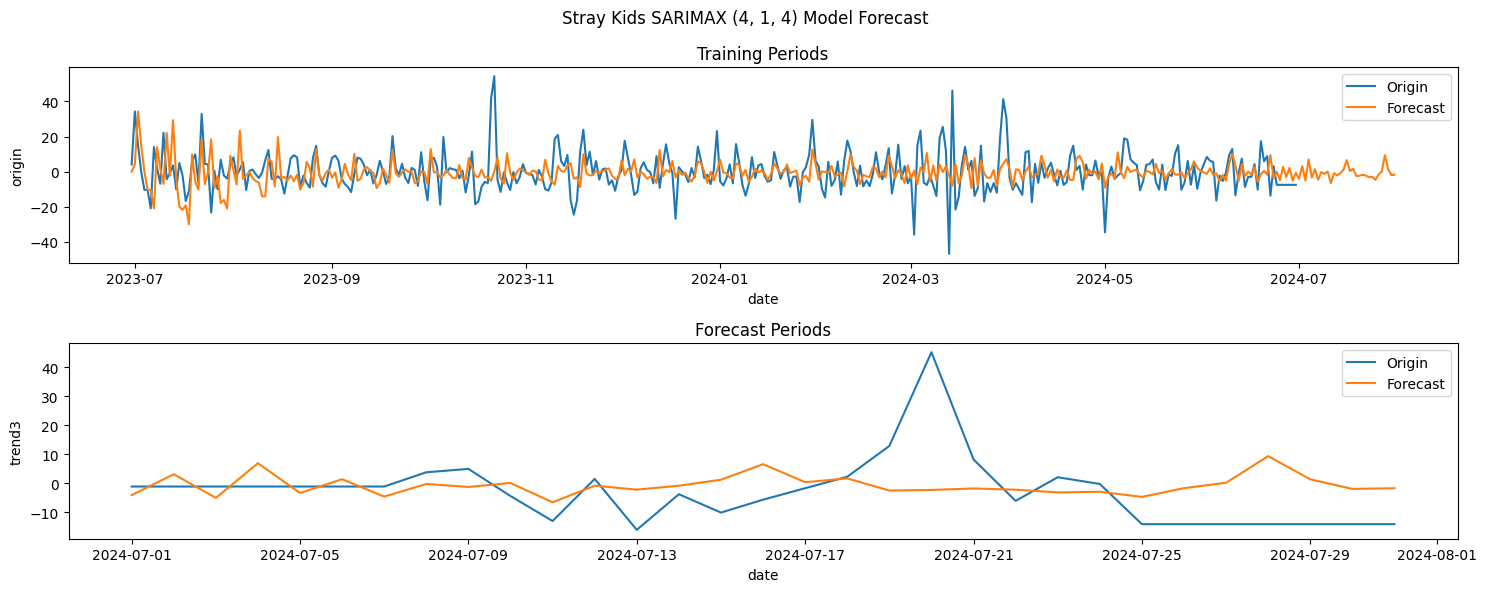

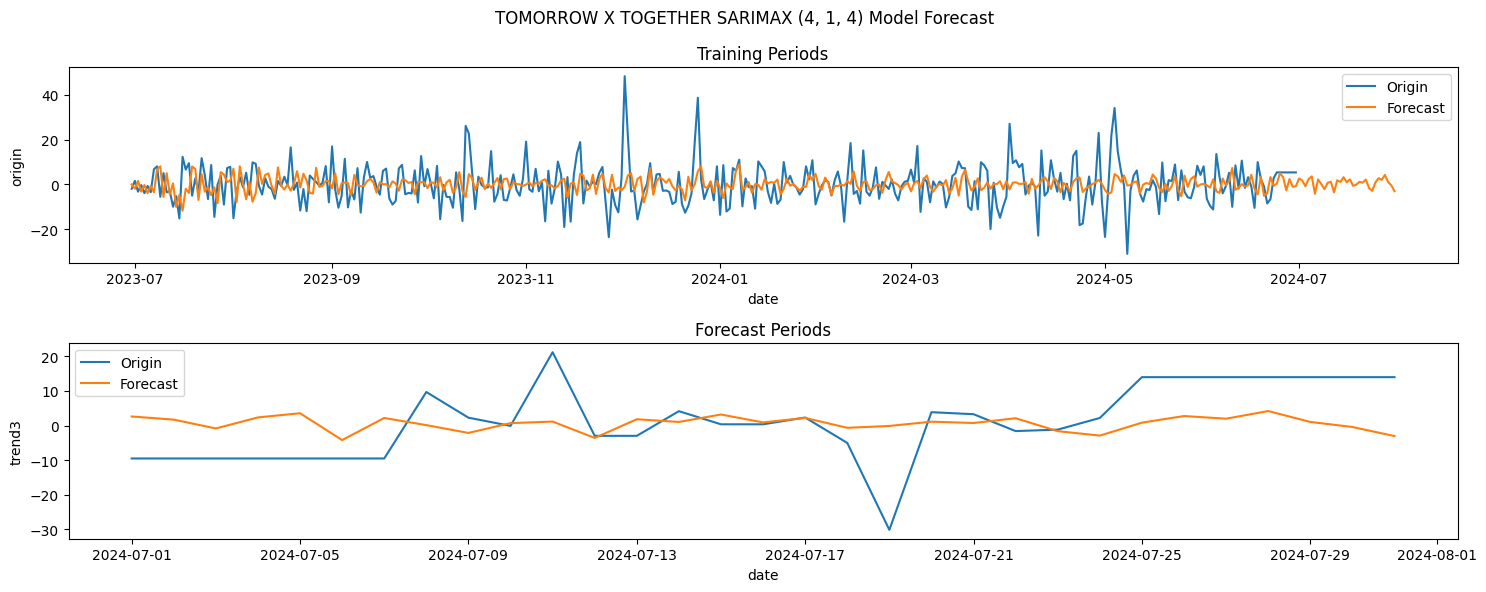

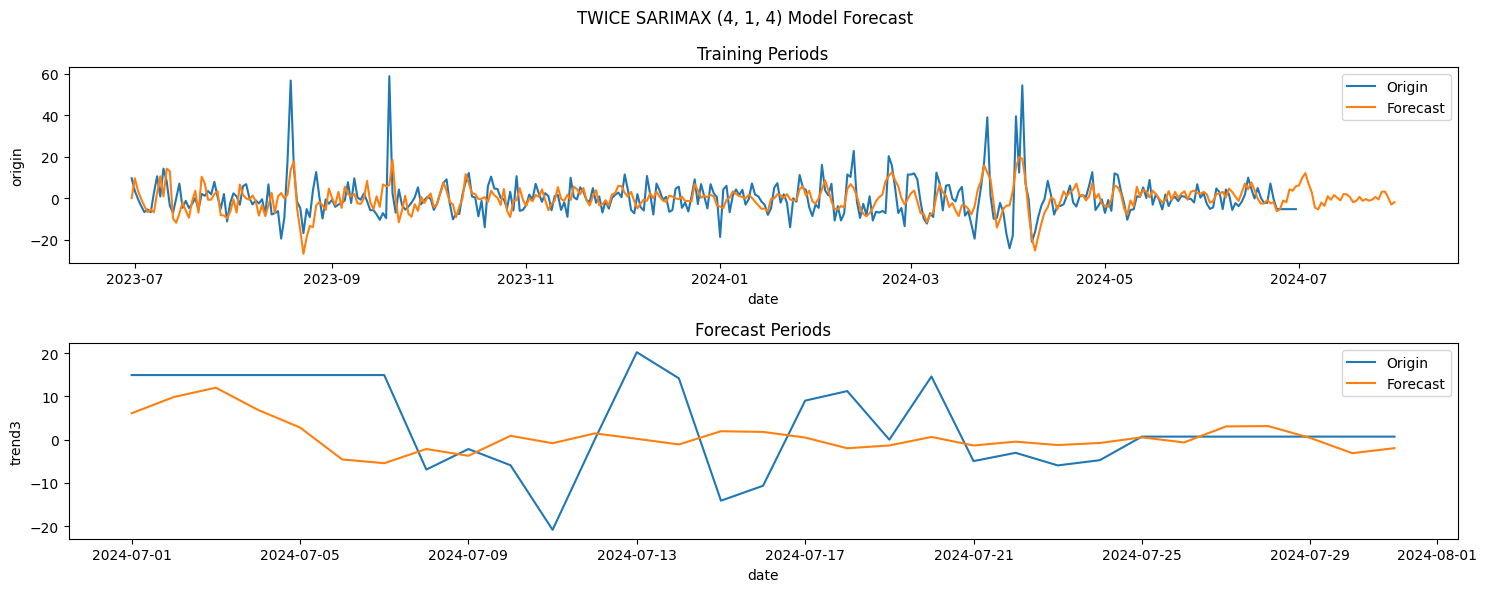

In [149]:
# 예측 결과 시각화
for artist in forecast_arima_df['artist'].unique():

    fig, axes = plt.subplots(2, 1, figsize=(15, 6))
    plt.suptitle(f'{artist} SARIMAX (4, 1, 4) Model Forecast')

    axes[0].set_title('Training Periods')
    sns.lineplot(data=forecast_arima_df[forecast_arima_df['artist'] == artist], x='date', y='origin', label='Origin', ax=axes[0])
    sns.lineplot(data=forecast_arima_df[forecast_arima_df['artist'] == artist], x='date', y='forecast', label='Forecast', ax=axes[0])

    axes[1].set_title('Forecast Periods')
    sns.lineplot(data=google_trend_test_df2[google_trend_test_df2['artist'] == artist], x='date', y='trend3', label='Origin', ax=axes[1])
    sns.lineplot(data=forecast_arima_df[forecast_arima_df['artist'] == artist].query("date >= '2024-07-01'"), x='date', y='forecast', label='Forecast', ax=axes[1])

    plt.legend()
    plt.tight_layout()

    plt.show()

## 외부변수 적용

In [153]:
# training google trend 와 병합
google_trend_album_test_df = google_trend_test_df.reset_index().merge(album_info_df, how='left', left_on=['artist', 'date'], right_on=['artist_name', 'release_date']).drop('artist_name', axis=1)
google_trend_album_test_df

date  trend artist album_name album_type release_date  track_cnt  \
0   2024-07-01     76  aespa        NaN        NaN          NaT        NaN   
1   2024-07-02     87  aespa   Hot Mess     Single   2024-07-02        3.0   
2   2024-07-03    100  aespa        NaN        NaN          NaT        NaN   
3   2024-07-04     96  aespa        NaN        NaN          NaT        NaN   
4   2024-07-05     67  aespa        NaN        NaN          NaT        NaN   
..         ...    ...    ...        ...        ...          ...        ...   
274 2024-07-27     46  TWICE        NaN        NaN          NaT        NaN   
275 2024-07-28     50  TWICE        NaN        NaN          NaT        NaN   
276 2024-07-29     43  TWICE        NaN        NaN          NaT        NaN   
277 2024-07-30     47  TWICE        NaN        NaN          NaT        NaN   
278 2024-07-31    100  TWICE        NaN        NaN          NaT        NaN   

     avg_track_play_time  
0                    NaN  
1          194914.333333  
2                    NaN  
3                    NaN  
4                    NaN  
..                   ...  
274                  NaN  
275                  NaN  
276                  NaN  
277                  NaN  
278                  NaN  

[279 rows x 8 columns]

In [154]:
# 앨범 발매일 이후 7일 동일 데이터 적용
# 앨범 초동 판매량 집계 기준일에 따라 7일 적용
for i, row in google_trend_album_test_df.iterrows():

    artist = row['artist']
    release_date = row['release_date']
    end_date = release_date + pd.Timedelta(days=7)  # 발매일 이후 7일

    # 해당 기간에 데이터 할당
    mask = (google_trend_album_test_df['artist'] == artist) & \
           (google_trend_album_test_df['date'] >= release_date) & (google_trend_album_test_df['date'] < end_date)

    google_trend_album_test_df.loc[mask, 'release_date'] = row['release_date']
    google_trend_album_test_df.loc[mask, 'album_name'] = row['album_name']
    google_trend_album_test_df.loc[mask, 'album_type'] = row['album_type']

    google_trend_album_test_df.loc[mask, 'track_cnt'] = row['track_cnt']
    google_trend_album_test_df.loc[mask, 'avg_track_play_time'] = row['avg_track_play_time']

google_trend_album_test_df[google_trend_album_test_df['album_name'].isnull() == False]

date  trend               artist   album_name album_type  \
1   2024-07-02     87                aespa     Hot Mess     Single   
2   2024-07-03    100                aespa     Hot Mess     Single   
3   2024-07-04     96                aespa     Hot Mess     Single   
4   2024-07-05     67                aespa     Hot Mess     Single   
5   2024-07-06     89                aespa     Hot Mess     Single   
6   2024-07-07     78                aespa     Hot Mess     Single   
7   2024-07-08     71                aespa     Hot Mess     Single   
218 2024-07-02     79  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
219 2024-07-03     86  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
220 2024-07-04     74  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
221 2024-07-05     77  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
222 2024-07-06     78  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
223 2024-07-07     71  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   
224 2024-07-08     90  TOMORROW X TOGETHER  誓い (CHIKAI)     Single   

    release_date  track_cnt  avg_track_play_time  
1     2024-07-02        3.0        194914.333333  
2     2024-07-02        3.0        194914.333333  
3     2024-07-02        3.0        194914.333333  
4     2024-07-02        3.0        194914.333333  
5     2024-07-02        3.0        194914.333333  
6     2024-07-02        3.0        194914.333333  
7     2024-07-02        3.0        194914.333333  
218   2024-07-02        3.0        174333.000000  
219   2024-07-02        3.0        174333.000000  
220   2024-07-02        3.0        174333.000000  
221   2024-07-02        3.0        174333.000000  
222   2024-07-02        3.0        174333.000000  
223   2024-07-02        3.0        174333.000000  
224   2024-07-02        3.0        174333.000000

In [155]:
# 앨범 장르 인코딩
encoded_album_type_test_df = pd.get_dummies(google_trend_album_test_df['album_type'])
google_trend_album_test_df = pd.concat([google_trend_album_test_df, encoded_album_type_test_df], axis=1)

# 모든 bool 타입 열을 1/0으로 변환
google_trend_album_test_df = google_trend_album_test_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

google_trend_album_test_df

date  trend artist album_name album_type release_date  track_cnt  \
0   2024-07-01     76  aespa        NaN        NaN          NaT        NaN   
1   2024-07-02     87  aespa   Hot Mess     Single   2024-07-02        3.0   
2   2024-07-03    100  aespa   Hot Mess     Single   2024-07-02        3.0   
3   2024-07-04     96  aespa   Hot Mess     Single   2024-07-02        3.0   
4   2024-07-05     67  aespa   Hot Mess     Single   2024-07-02        3.0   
..         ...    ...    ...        ...        ...          ...        ...   
274 2024-07-27     46  TWICE        NaN        NaN          NaT        NaN   
275 2024-07-28     50  TWICE        NaN        NaN          NaT        NaN   
276 2024-07-29     43  TWICE        NaN        NaN          NaT        NaN   
277 2024-07-30     47  TWICE        NaN        NaN          NaT        NaN   
278 2024-07-31    100  TWICE        NaN        NaN          NaT        NaN   

     avg_track_play_time  Single  
0                    NaN       0  
1          194914.333333       1  
2          194914.333333       1  
3          194914.333333       1  
4          194914.333333       1  
..                   ...     ...  
274                  NaN       0  
275                  NaN       0  
276                  NaN       0  
277                  NaN       0  
278                  NaN       0  

[279 rows x 9 columns]

In [156]:
google_trend_album_test_df = google_trend_album_test_df.drop(['album_type'], axis=1)
google_trend_album_test_df

date  trend artist album_name release_date  track_cnt  \
0   2024-07-01     76  aespa        NaN          NaT        NaN   
1   2024-07-02     87  aespa   Hot Mess   2024-07-02        3.0   
2   2024-07-03    100  aespa   Hot Mess   2024-07-02        3.0   
3   2024-07-04     96  aespa   Hot Mess   2024-07-02        3.0   
4   2024-07-05     67  aespa   Hot Mess   2024-07-02        3.0   
..         ...    ...    ...        ...          ...        ...   
274 2024-07-27     46  TWICE        NaN          NaT        NaN   
275 2024-07-28     50  TWICE        NaN          NaT        NaN   
276 2024-07-29     43  TWICE        NaN          NaT        NaN   
277 2024-07-30     47  TWICE        NaN          NaT        NaN   
278 2024-07-31    100  TWICE        NaN          NaT        NaN   

     avg_track_play_time  Single  
0                    NaN       0  
1          194914.333333       1  
2          194914.333333       1  
3          194914.333333       1  
4          194914.333333       1  
..                   ...     ...  
274                  NaN       0  
275                  NaN       0  
276                  NaN       0  
277                  NaN       0  
278                  NaN       0  

[279 rows x 8 columns]

In [157]:
# 미존재 앨범 타입 더미 변수 추가
for col in ['Broadcast', 'EP', 'Other', 'Album']:
    google_trend_album_test_df[col] = 0

In [158]:
# 최신 앨범 발매일 도달 기간
google_trend_album_test_df['release_duration'] = (google_trend_album_test_df['date'] - google_trend_album_test_df['release_date']).dt.days
google_trend_album_test_df

date  trend artist album_name release_date  track_cnt  \
0   2024-07-01     76  aespa        NaN          NaT        NaN   
1   2024-07-02     87  aespa   Hot Mess   2024-07-02        3.0   
2   2024-07-03    100  aespa   Hot Mess   2024-07-02        3.0   
3   2024-07-04     96  aespa   Hot Mess   2024-07-02        3.0   
4   2024-07-05     67  aespa   Hot Mess   2024-07-02        3.0   
..         ...    ...    ...        ...          ...        ...   
274 2024-07-27     46  TWICE        NaN          NaT        NaN   
275 2024-07-28     50  TWICE        NaN          NaT        NaN   
276 2024-07-29     43  TWICE        NaN          NaT        NaN   
277 2024-07-30     47  TWICE        NaN          NaT        NaN   
278 2024-07-31    100  TWICE        NaN          NaT        NaN   

     avg_track_play_time  Single  Broadcast  EP  Other  Album  \
0                    NaN       0          0   0      0      0   
1          194914.333333       1          0   0      0      0   
2          194914.333333       1          0   0      0      0   
3          194914.333333       1          0   0      0      0   
4          194914.333333       1          0   0      0      0   
..                   ...     ...        ...  ..    ...    ...   
274                  NaN       0          0   0      0      0   
275                  NaN       0          0   0      0      0   
276                  NaN       0          0   0      0      0   
277                  NaN       0          0   0      0      0   
278                  NaN       0          0   0      0      0   

     release_duration  
0                 NaN  
1                 0.0  
2                 1.0  
3                 2.0  
4                 3.0  
..                ...  
274               NaN  
275               NaN  
276               NaN  
277               NaN  
278               NaN  

[279 rows x 13 columns]

In [160]:
# 앨범 데이터 적용
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import pandas as pd

forecast_arima_ext_df_list = []
for artist in tqdm(google_trend_album_df['artist'].unique()):

    artist_trend_df = google_trend_album_df[google_trend_album_df['artist'] == artist].reset_index(drop=True)

    # 아티스트 별 수집 마지막 기간으로부터 이전 1년 데이터만 사용
    start_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] - pd.DateOffset(years=1)

    trend_df = artist_trend_df[artist_trend_df['date'] >= start_date].reset_index(drop=True)[['date', 'trend3', 'release_duration', 'track_cnt', 'avg_track_play_time', 'Album', 'Broadcast', 'EP', 'Other', 'Single']]
    trend_df = trend_df.fillna(0)

    # ARIMA 모델 적합 (p, d, q 값은 ACF, PACF 결과를 기반으로 설정)
    model = SARIMAX(
        endog=trend_df['trend3'],
        order=(4, 1, 4),
        seasonal_order=(4, 1, 4, 12),
        exog=trend_df[['release_duration', 'track_cnt', 'avg_track_play_time', 'Album', 'Broadcast', 'EP', 'Other', 'Single']] # 앨범 데이터 적용
    )  # (p, d, q)는 ACF, PACF 결과를 바탕으로 설정 필요
    model_fit = model.fit(disp=False)

    print(f'<<<<<< {artist} >>>>>>')
    print(model_fit.summary())
    print('\n')

    # 모델 예측
    forecast_days_num = 31 # 훈련 기간 이후 예측하고자 하는 일수
    end_date = artist_trend_df.loc[len(artist_trend_df)-1, 'date'] + pd.DateOffset(days=forecast_days_num)  # 이후 한 달 예측

    date_df = pd.date_range(start=start_date, end=end_date, freq='D')
    date_df = pd.DataFrame(date_df, columns=['date'])

    # 앨범 데이터 추가
    test_exog_df = google_trend_album_test_df[google_trend_album_test_df['artist'] == artist].reset_index(drop=True)[['release_duration', 'track_cnt', 'avg_track_play_time', 'Album', 'Broadcast', 'EP', 'Other', 'Single']]
    test_exog_df = test_exog_df.fillna(0)

    predict_df = model_fit.get_prediction(start=trend_df.index[0], end=trend_df.index[-1]+forecast_days_num, exog=test_exog_df).predicted_mean # 훈련 기간 예측 결과 + 이후 한 달 forecast

    # 예측 결과를 DataFrame으로 결합
    result_df = pd.concat([date_df, predict_df], axis=1).merge(
        google_trend_df2[google_trend_df2['artist'] == artist][['date', 'trend3']],
        how='left',
        on='date'
    )
    result_df.columns = ['date', 'forecast', 'origin']

    result_df['artist'] = artist
    forecast_arima_ext_df_list.append(result_df)

forecast_arima_ext_df = pd.concat(forecast_arima_ext_df_list, ignore_index=True)
forecast_arima_ext_df

  0%|          | 0/9 [00:00<?, ?it/s]

<<<<<< aespa >>>>>>
                                     SARIMAX Results                                      
Dep. Variable:                             trend3   No. Observations:                  367
Model:             SARIMAX(4, 1, 4)x(4, 1, 4, 12)   Log Likelihood               -1246.975
Date:                            Tue, 13 Aug 2024   AIC                           2543.951
Time:                                    08:24:30   BIC                           2640.683
Sample:                                         0   HQIC                          2582.437
                                            - 367                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
release_duration       -1.4923      1.146     -1.302      0.193      -3.739 

date   forecast    origin artist
0    2023-06-30   0.000000 -7.416667  aespa
1    2023-07-01  -7.416236  0.791667  aespa
2    2023-07-02   0.790849 -6.375000  aespa
3    2023-07-03  -6.374495 -0.625000  aespa
4    2023-07-04  -0.625230 -5.166667  aespa
...         ...        ...       ...    ...
3581 2024-07-27  -8.599658       NaN  TWICE
3582 2024-07-28  -8.519875       NaN  TWICE
3583 2024-07-29  -8.556157       NaN  TWICE
3584 2024-07-30 -12.255567       NaN  TWICE
3585 2024-07-31 -10.833604       NaN  TWICE

[3586 rows x 4 columns]

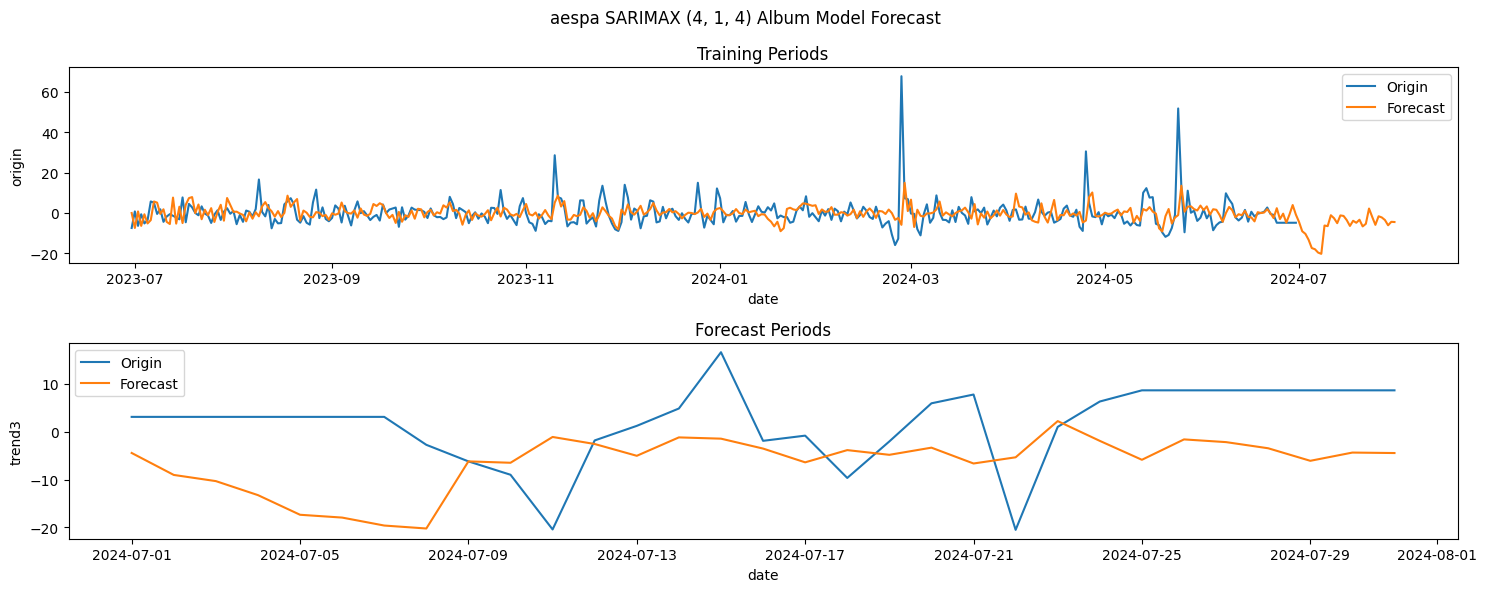

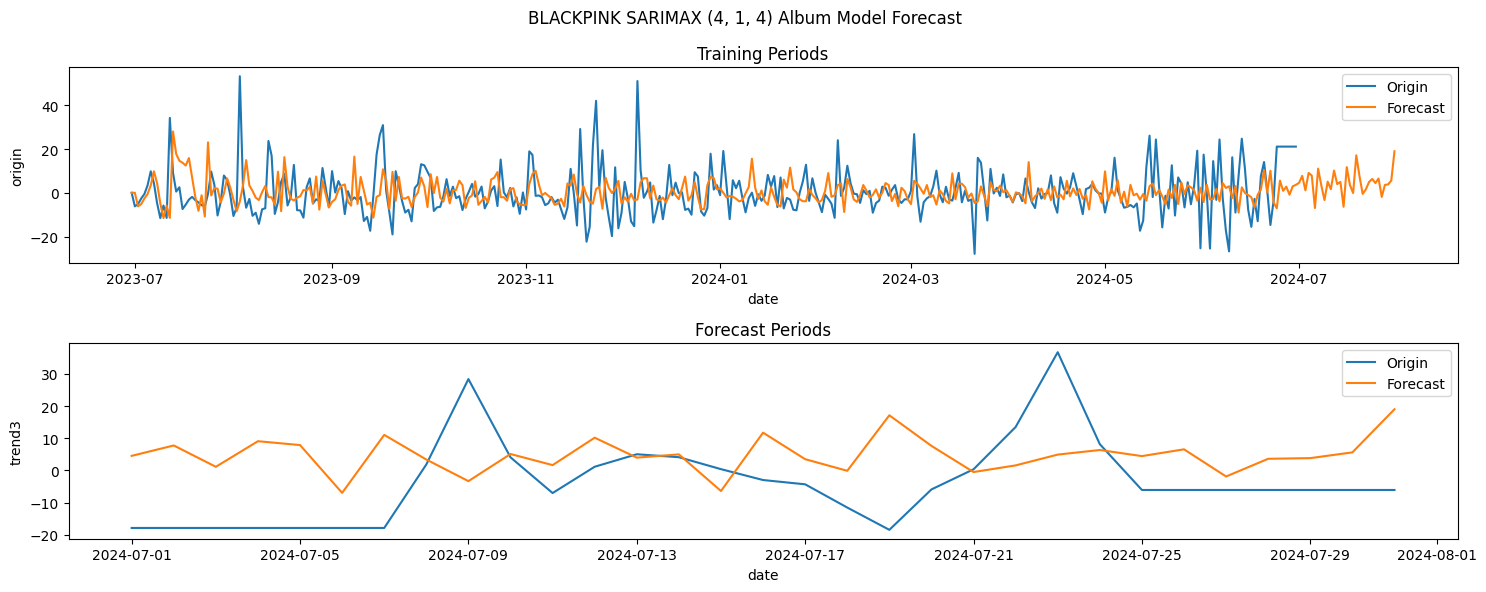

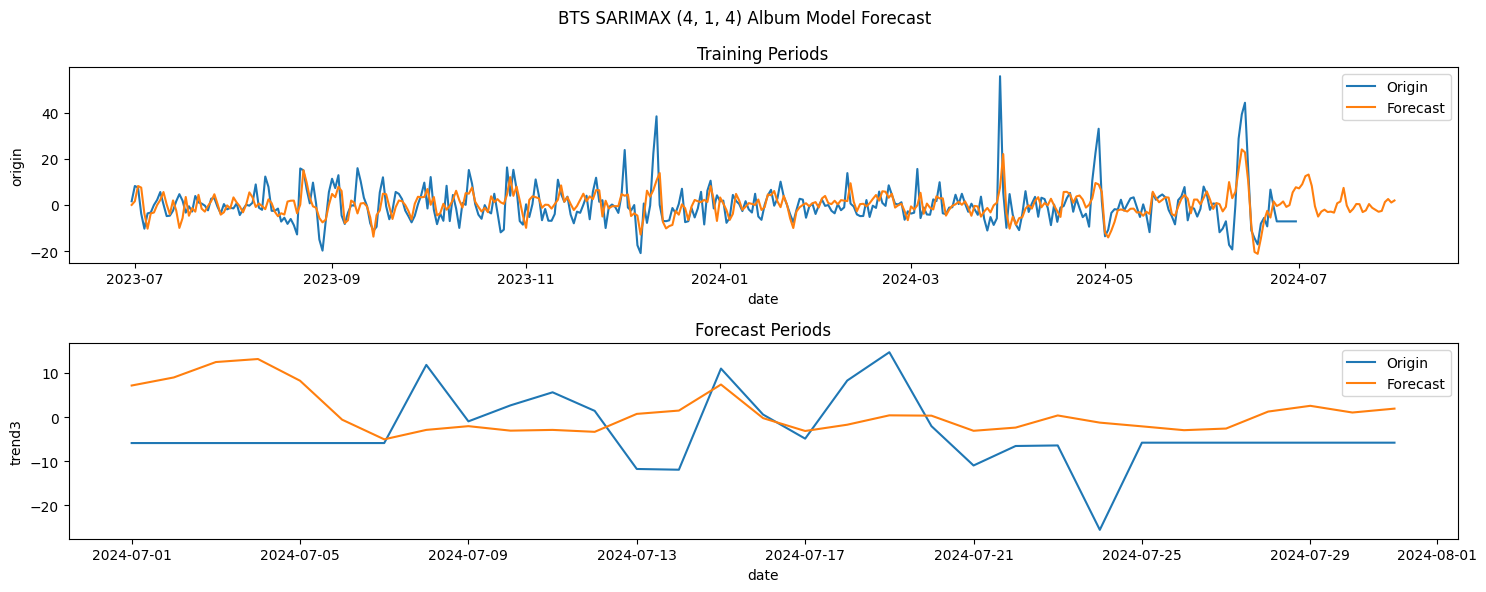

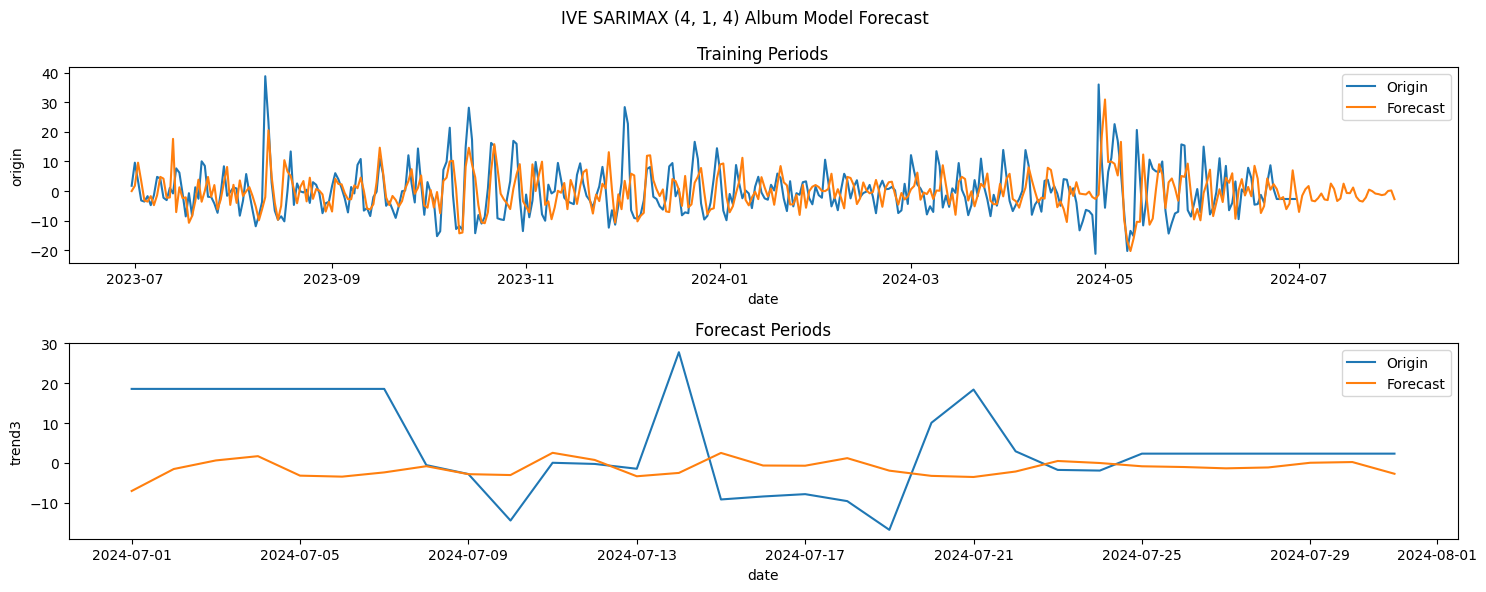

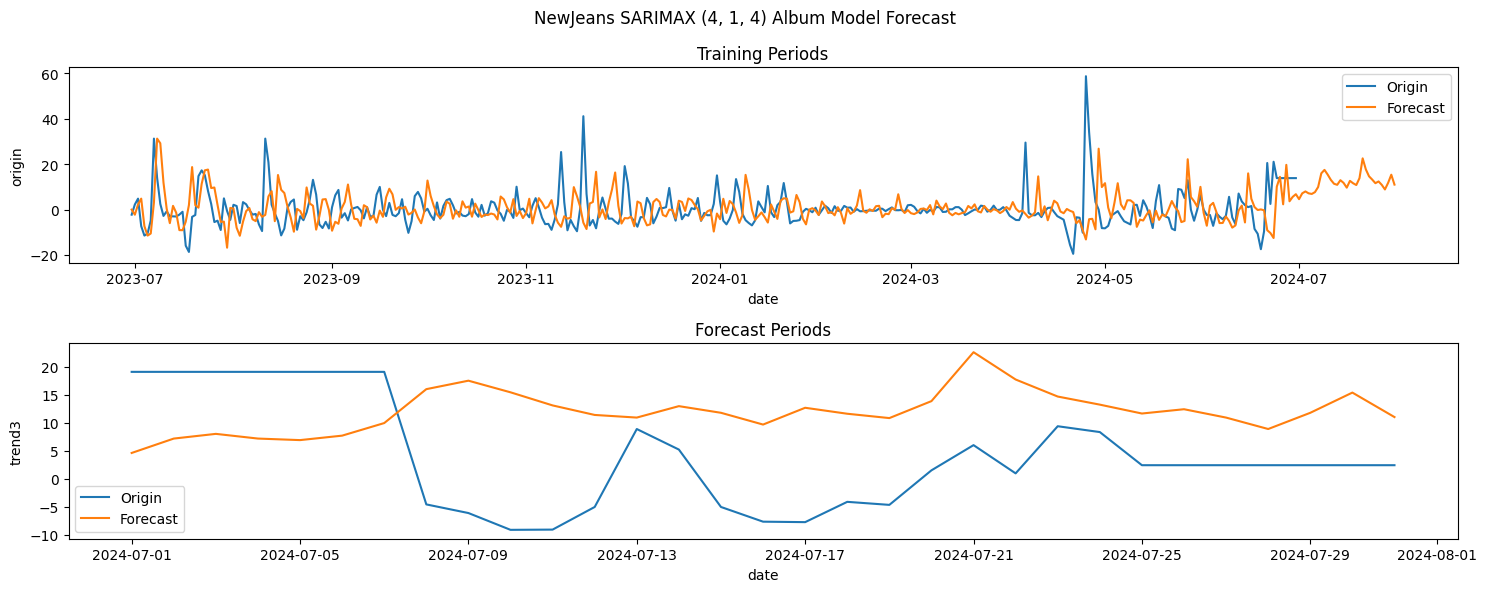

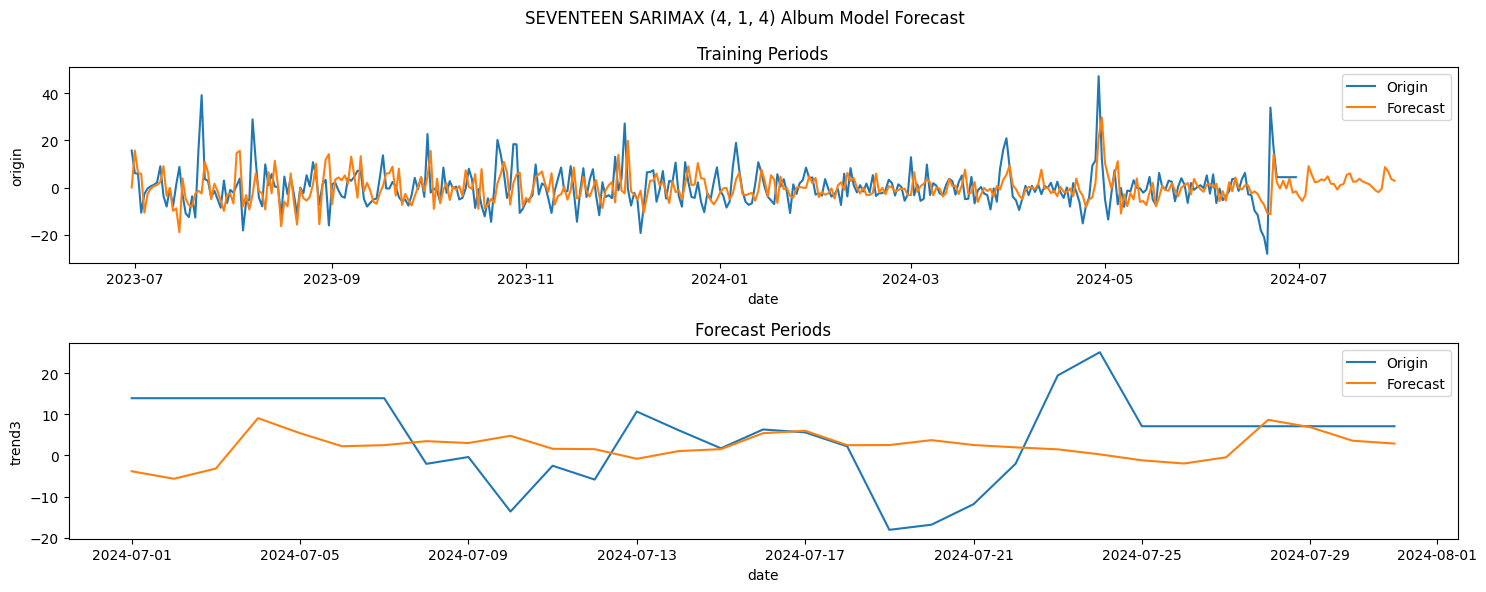

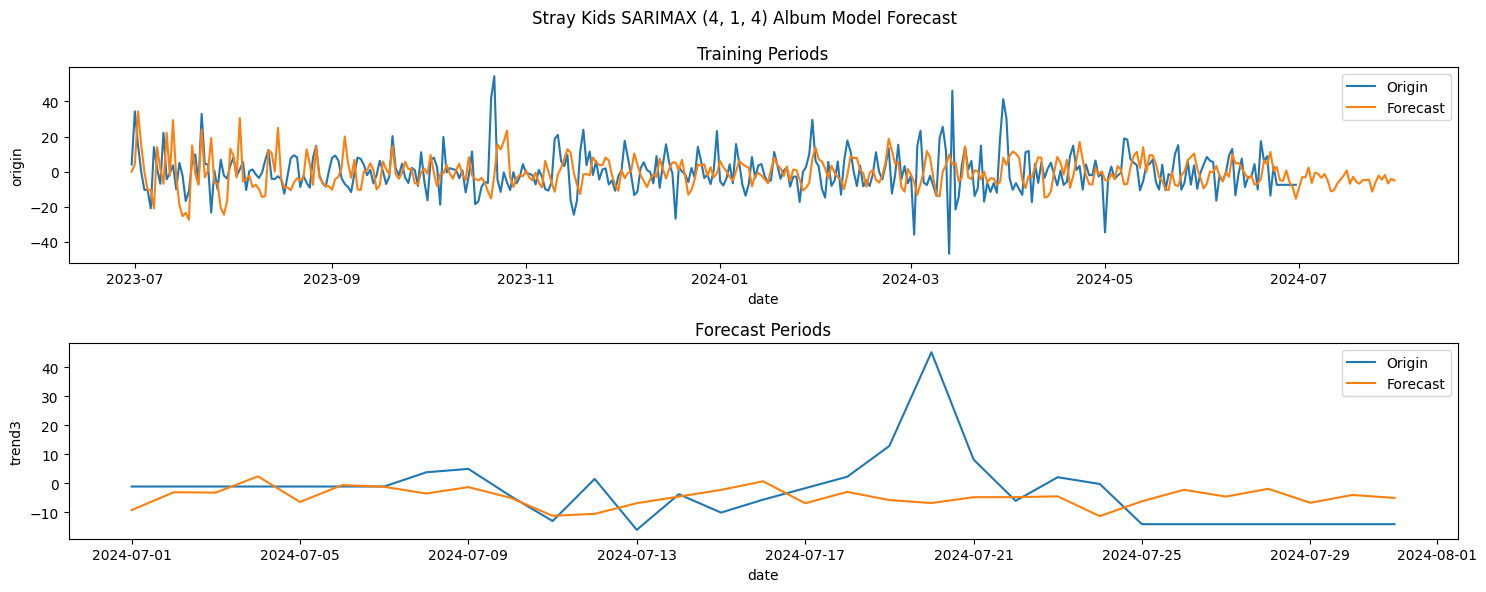

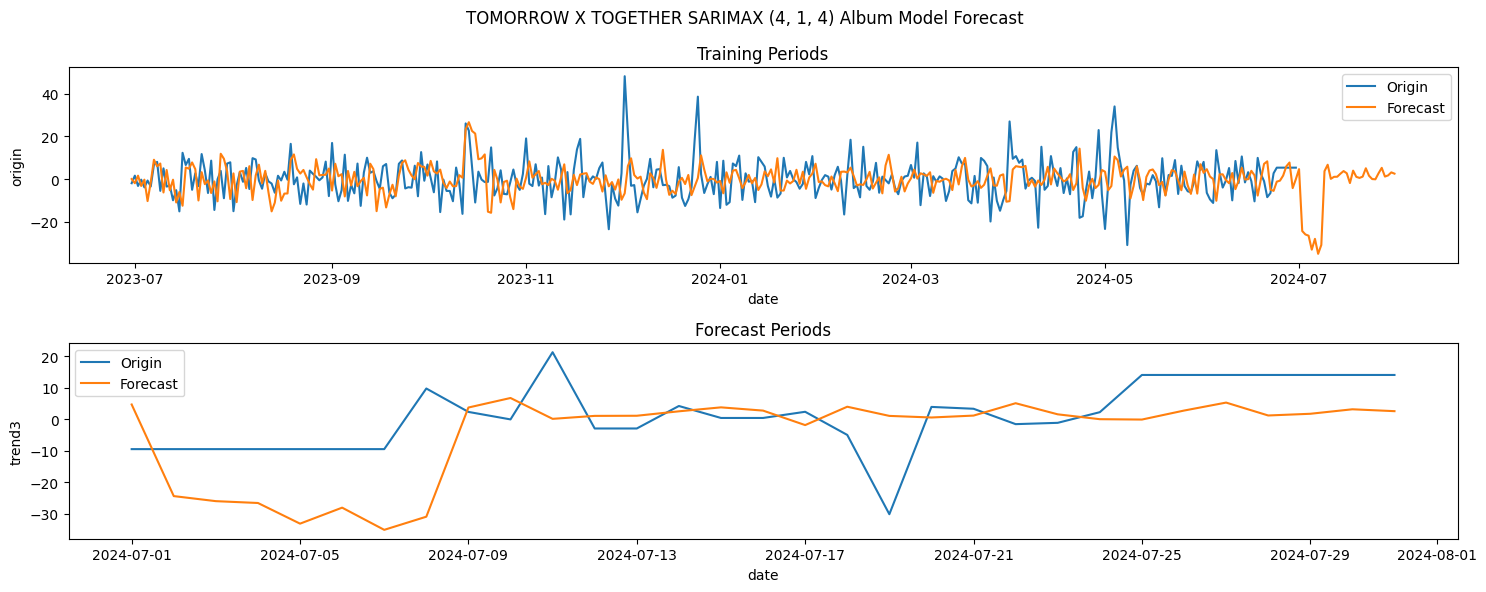

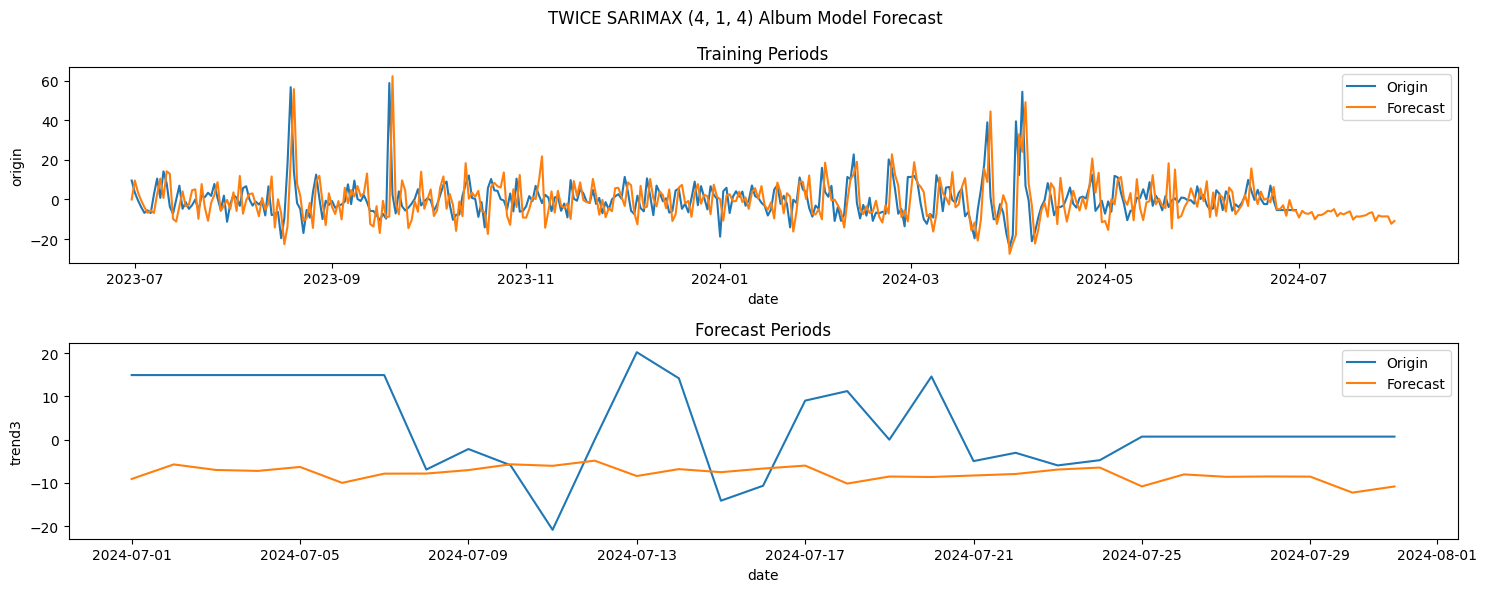

In [161]:
# 예측 결과 시각화
for artist in forecast_arima_ext_df['artist'].unique():

    fig, axes = plt.subplots(2, 1, figsize=(15, 6))
    plt.suptitle(f'{artist} SARIMAX (4, 1, 4) Album Model Forecast')

    axes[0].set_title('Training Periods')
    sns.lineplot(data=forecast_arima_ext_df[forecast_arima_ext_df['artist'] == artist], x='date', y='origin', label='Origin', ax=axes[0])
    sns.lineplot(data=forecast_arima_ext_df[forecast_arima_ext_df['artist'] == artist], x='date', y='forecast', label='Forecast', ax=axes[0])

    axes[1].set_title('Forecast Periods')
    sns.lineplot(data=google_trend_test_df2[google_trend_test_df2['artist'] == artist], x='date', y='trend3', label='Origin', ax=axes[1])
    sns.lineplot(data=forecast_arima_ext_df[forecast_arima_ext_df['artist'] == artist].query("date >= '2024-07-01'"), x='date', y='forecast', label='Forecast', ax=axes[1])

    plt.legend()
    plt.tight_layout()

    plt.show()